# Hyperparameter Search for Lung X-ray Classification




**Goal**: Exploring how different hyper-parameters (head depth, batch size, optimizer) affect performance. The end-product is the model configuration that yields the best weighted AUPRC on the test set.

**Notebook Structure**

1. **Setup & Imports** – load libraries, enable mixed precision, add a RAM-trimming helper.  
2. **Data Loading** – read Excel metadata and pre-processed image tensors for both *full-slice* and *nodule* crops.
  * **Full 5** (`full5_mix.npz`) *5 classes full-slice*  
  * **Nodule 5** (`nod5_mix.npz`) *5-class nodule-focused*
3. **Quick Exploration** – visualise one sample per class, show value ranges, and plot class distributions.  
4. **Hyper-parameter Sweeps**  
   * *Classifier-Head search* – test several dense-layer layouts.  
   * *Batch-Size search* – try 16, 32, 64.  
   * *Optimizer search* – compare RMSprop, SGD, AdamW, Adam.  
5. **Training Engine** – `train_three_stage()` handles head-only training, partial unfreeze, and full fine-tuning with linear LR decay.  
6. **Evaluation** – `evaluate_model()` produces learning curves, confusion matrices, per-class metrics, and summary tables for each experiment.

## Import Libraries
Import required libraries, define a RAM-trimming function, and enable mixed precision

In [ ]:
import os
import gc
import ctypes
import random
import itertools

import pandas as pd
import numpy as np
from scipy import stats
from math import ceil

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.applications.convnext import (
    EfficientNetB0,
    ConvNeXtTiny,
    preprocess_input as preprocess_convnext
    )

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
    auc
    )


def trim_ram():
    libc = ctypes.CDLL("libc.so.6")
    result = libc.malloc_trim(0)
    tf.keras.backend.clear_session()
    plt.close('all')
    gc.collect()
    print("malloc_trim result:", result)


mixed_precision.set_global_policy("mixed_float16")

2025-05-03 12:29:26.594384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746275366.814354      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746275366.875875      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Data
### Load Excel File
Load the lung dataset from Excel into a DataFrame and display its contents and shape

In [ ]:
file_path = '/kaggle/input/ai-in-biomed-dataset-lung/dataset_lung.xlsx'
df = pd.read_excel(file_path)

print(df)
print("File Shape: ", df.shape)

                  Full_slice               Nodule  TumorClass
0        pat1_fullslice.nrrd     pat1_nodule.nrrd           5
1        pat2_fullslice.nrrd     pat2_nodule.nrrd           5
2        pat3_fullslice.nrrd     pat3_nodule.nrrd           2
3        pat4_fullslice.nrrd     pat4_nodule.nrrd           5
4        pat5_fullslice.nrrd     pat5_nodule.nrrd           4
...                      ...                  ...         ...
2358  pat2368_fullslice.nrrd  pat2368_nodule.nrrd           2
2359  pat2369_fullslice.nrrd  pat2369_nodule.nrrd           2
2360  pat2387_fullslice.nrrd  pat2387_nodule.nrrd           5
2361  pat2399_fullslice.nrrd  pat2399_nodule.nrrd           5
2362  pat2415_fullslice.nrrd  pat2415_nodule.nrrd           5

[2363 rows x 3 columns]
File Shape:  (2363, 3)


### Load Images

In [ ]:
def load_print_merge(npz_path):

    data = np.load(npz_path)

    print("Original shapes:")

    for key in data:
        print(f"  {key}: {data[key].shape}")

    X_train = data['X_train']
    y_train = data['y_train']
    X_val   = data['X_val']
    y_val   = data['y_val']
    X_test  = data['X_test']
    y_test  = data['y_test']

    print("\nAfter merging train + val:")
    print(f"  X_train: {X_train.shape}")
    print(f"  y_train: {y_train.shape}")
    print(f"  X_val: {X_val.shape}")
    print(f"  y_val: {y_val.shape}")
    print(f"  X_test : {X_test.shape}")
    print(f"  y_test : {y_test.shape}")

    return X_train, y_train, X_val, y_val, X_test, y_test

#load full_slice data
X_train, y_train, X_val, y_val, X_test, y_test = load_print_merge('/kaggle/input/ai-in-biomed-dataset-lung/full5_mix.npz')

Original shapes:
  X_train: (4365, 224, 224)
  y_train: (4365,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test: (237, 224, 224)
  y_test: (237,)

After merging train + val:
  X_train: (4365, 224, 224)
  y_train: (4365,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test : (237, 224, 224)
  y_test : (237,)


In [ ]:
#load nodule data
X_train, y_train, X_val, y_val, X_test, y_test = load_print_merge('/kaggle/input/ai-in-biomed-dataset-lung/nod5_mix.npz')

Original shapes:
  X_train: (3815, 224, 224)
  y_train: (3815,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test: (473, 224, 224)
  y_test: (473,)

After merging train + val:
  X_train: (3815, 224, 224)
  y_train: (3815,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test : (473, 224, 224)
  y_test : (473,)


## Visualize Data

This function displays one representative image per class from your dataset in a neat grid, labeling each subplot with its class name or numeric label. It gives a quick visual overview of class balance and the variety of examples in your training set.

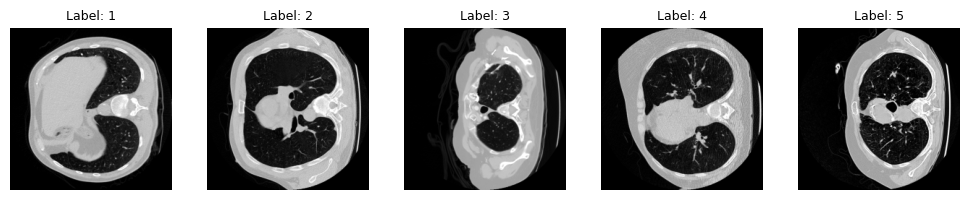

In [ ]:
def plot_one_per_class(X, y, names=None, cols=None, figsize=(8, 4)):
    classes = np.unique(y)
    n = len(classes)
    cols = cols or n
    rows = ceil(n/cols)
    mapping = {lbl: names[i] for i, lbl in enumerate(classes)} if names and len(names) == n else {}
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    for ax, lbl in zip(axes, classes):
        img = X[y == lbl][0]
        ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
        ax.set_title(f"Label: {mapping.get(lbl, lbl)}", fontsize=9)
        ax.axis('off')
    for ax in axes[n:]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
#fullslice
plot_one_per_class(X_train, y_train, figsize=(10, 2), cols=5)

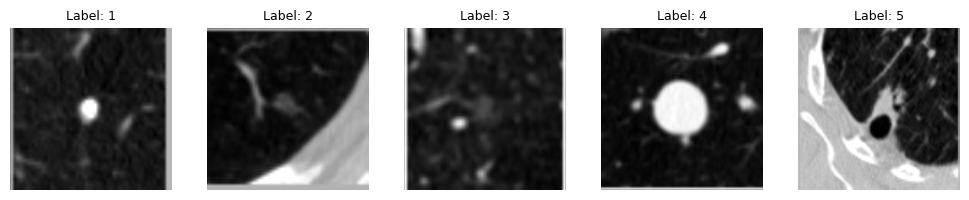

In [ ]:
#nodule
plot_one_per_class(X_train, y_train, figsize=(10, 2), cols=5)

## Classifier Head Search

###Full 5


#### Model

This section defines a ConvNeXtTiny‐based classifier with a custom ValidationMetrics callback, data pipeline helpers, and a linear learning‐rate decay scheduler. It then orchestrates a three‐stage training loop—head‐only, partial backbone fine‐tuning, and full network fine‐tuning—to maximize performance.

In [ ]:
class ValidationMetrics(callbacks.Callback):
    def __init__(self, val_dataset):
        super().__init__()
        self.val_ds = val_dataset
        self.history = {
            'val_balanced_accuracy': [],
            'val_f1_score': [],
            'val_weighted_auprc': []
        }

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []
        for x_batch, y_batch in self.val_ds:
            preds = self.model.predict(x_batch, verbose=0)
            y_true.append(y_batch.numpy())
            y_pred.append(preds)
        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)
        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)

        bal_acc = balanced_accuracy_score(y_true_labels, y_pred_labels)
        f1      = f1_score(y_true_labels, y_pred_labels, average='weighted')
        auprc_w = average_precision_score(y_true, y_pred, average='weighted')

        logs = logs or {}
        logs['val_balanced_accuracy'] = bal_acc
        logs['val_f1_score']          = f1
        logs['val_weighted_auprc']    = auprc_w

        self.history['val_balanced_accuracy'].append(bal_acc)
        self.history['val_f1_score'].append(f1)
        self.history['val_weighted_auprc'].append(auprc_w)

        print(
            f" — val_balanced_accuracy: {bal_acc:.4f}"
            f" — val_f1_score: {f1:.4f}"
            f" — val_weighted_auprc: {auprc_w:.4f}"
        )

def build_convnext_classifier(
    input_shape=(224, 224, 3),
    num_classes=5,
    dropout=0.5,
    head_layers=None
):
    """
    Build ConvNeXtTiny backbone with a customizable classification head.

    head_layers: list of ints specifying the sizes of each Dense layer, ending with num_classes.
    """
    base = ConvNeXtTiny(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(dropout)(x)

    # build head
    if head_layers is None:
        head_layers = [num_classes]

    for i, units in enumerate(head_layers):
        activation = 'softmax' if i == len(head_layers) - 1 else 'relu'
        x = layers.Dense(units, activation=activation, dtype='float32')(x)

    model = models.Model(inputs=base.input, outputs=x)
    return model, base

AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(X, y, batch_size=32, shuffle=False):
    def _prep(img, label):
        img = tf.cast(img, tf.float32)
        img = tf.expand_dims(img, axis=-1)
        img = tf.image.grayscale_to_rgb(img)
        img = tf.keras.applications.convnext.preprocess_input(img)
        return img, tf.one_hot(label - 1, depth=5)

    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    ds = ds.map(_prep, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

def linear_decay_scheduler(initial_lr, final_lr, total_epochs):
    def schedule_fn(epoch):
        frac = epoch / float(total_epochs - 1)
        return initial_lr + frac * (final_lr - initial_lr)
    return schedule_fn

def train_three_stage(
    X_train, y_train, X_val, y_val,
    head_layers,
    batch_size=32,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
):
    """
    Train ConvNeXtTiny model in three stages with a custom head.

    head_layers: list specifying Dense units for classification head.
    """
    train_ds = make_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
    val_ds   = make_dataset(X_val,   y_val,   batch_size=batch_size, shuffle=False)

    model, backbone = build_convnext_classifier(head_layers=head_layers)
    metrics_cb = ValidationMetrics(val_ds)
    es = callbacks.EarlyStopping(
        monitor='val_weighted_auprc', mode='max',
        patience=5, restore_best_weights=True, verbose=1
    )
    ckpt = callbacks.ModelCheckpoint(
        'best_model_{}.keras'.format('_'.join(map(str, head_layers))),
        monitor='val_weighted_auprc',
        mode='max', save_best_only=True, verbose=1
    )

    history_all = {k: [] for k in [
        'loss', 'accuracy', 'AUPRC',
        'val_loss', 'val_accuracy', 'val_AUPRC',
        'val_balanced_accuracy', 'val_f1_score', 'val_weighted_auprc'
    ]}

    def _fit(epochs, lr, lr_scheduler=None):
        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.AUC(curve='PR', name='AUPRC')
            ]
        )
        cbs = [metrics_cb, es, ckpt]
        if lr_scheduler:
            cbs.append(callbacks.LearningRateScheduler(lr_scheduler, verbose=1))
        h = model.fit(
            train_ds, validation_data=val_ds,
            epochs=epochs,
            callbacks=cbs,
            verbose=1
        )
        for k in history_all:
            if k in h.history:
                history_all[k] += h.history[k]
        return h

    # Stage 1: train head only
    for layer in backbone.layers:
        layer.trainable = False
    for layer in model.layers[len(backbone.layers):]:
        layer.trainable = True
    print("\n=== Stage 1: Training head only (lr=1e-3) ===")
    _fit(stage1_epochs, lr=1e-3)

    # Stage 2: fine-tune last 40% of backbone
    n = len(backbone.layers)
    k = int(n * 0.4)
    for layer in backbone.layers[: n - k]:
        layer.trainable = False
    for layer in backbone.layers[n - k:]:
        layer.trainable = True
    print(f"\n=== Stage 2: Fine-tune last 40% (lr 1e-4→1e-5 over {stage2_epochs} epochs) ===")
    sched2 = linear_decay_scheduler(initial_lr=1e-4, final_lr=1e-5, total_epochs=stage2_epochs)
    _fit(stage2_epochs, lr=1e-4, lr_scheduler=sched2)

    # Stage 3: fine-tune whole network
    for layer in backbone.layers:
        layer.trainable = True
    print(f"\n=== Stage 3: Fine-tune whole network (lr 1e-5→1e-6 over {stage3_epochs} epochs) ===")
    sched3 = linear_decay_scheduler(initial_lr=1e-5,
                                    final_lr=1e-6,
                                    total_epochs=stage3_epochs)

    _fit(stage3_epochs, lr=1e-5, lr_scheduler=sched3)

    np.save(f'training_history_{"_".join(map(str, head_layers))}.npy', history_all)
    print(f"History saved to training_history_{'_'.join(map(str, head_layers))}.npy")

    return model, history_all

In [ ]:
model1, history1 = train_three_stage(
    X_train, y_train, X_val, y_val,
    head_layers=[5],
    batch_size=16,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

model2, history2 = train_three_stage(
    X_train, y_train, X_val, y_val,
    head_layers=[128, 5],
    batch_size=16,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

model3, history3 = train_three_stage(
    X_train, y_train, X_val, y_val,
    head_layers=[256, 128, 5],
    batch_size=16,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

I0000 00:00:1746275393.217731      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

=== Stage 1: Training head only (lr=1e-3) ===
Epoch 1/10


I0000 00:00:1746275415.960938      59 service.cc:148] XLA service 0x7b5cf0002470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746275415.962970      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746275417.694387      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/273 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - AUPRC: 0.2190 - accuracy: 0.2604 - loss: 1.8714   

I0000 00:00:1746275422.616103      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - AUPRC: 0.2203 - accuracy: 0.2325 - loss: 1.7095 — val_balanced_accuracy: 0.1820 — val_f1_score: 0.2565 — val_weighted_auprc: 0.3120

Epoch 1: val_weighted_auprc improved from -inf to 0.31203, saving model to best_model_5.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 63s 143ms/step - AUPRC: 0.2203 - accuracy: 0.2326 - loss: 1.7093 - val_AUPRC: 0.2703 - val_accuracy: 0.2743 - val_loss: 1.5582 - val_balanced_accuracy: 0.1820 - val_f1_score: 0.2565 - val_weighted_auprc: 0.3120
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - AUPRC: 0.2741 - accuracy: 0.2970 - loss: 1.5609 — val_balanced_accuracy: 0.2721 — val_f1_score: 0.2747 — val_weighted_auprc: 0.3316

Epoch 2: val_weighted_auprc improved from 0.31203 to 0.33160, saving model to best_model_5.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - AUPRC: 0.2741 - accuracy: 0.2970 - loss: 1.5609 - val_AUPRC: 0.2664 - val_accuracy: 0.2869 - val_loss: 1.5684 - val_balanced_accuracy: 0.2721 - val_f1_score: 0

E0000 00:00:1746275610.873240      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746275611.049091      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746275611.290101      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746275611.485030      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


272/273 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - AUPRC: 0.3988 - accuracy: 0.3932 - loss: 1.4091

E0000 00:00:1746275648.701126      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746275648.877136      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746275649.109457      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746275649.304201      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - AUPRC: 0.3989 - accuracy: 0.3932 - loss: 1.4089 — val_balanced_accuracy: 0.3230 — val_f1_score: 0.3215 — val_weighted_auprc: 0.3615

Epoch 1: val_weighted_auprc improved from 0.34401 to 0.36146, saving model to best_model_5.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 105s 224ms/step - AUPRC: 0.3990 - accuracy: 0.3933 - loss: 1.4087 - val_AUPRC: 0.2825 - val_accuracy: 0.3165 - val_loss: 1.5514 - val_balanced_accuracy: 0.3230 - val_f1_score: 0.3215 - val_weighted_auprc: 0.3615 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.357142857142858e-05.
Epoch 2/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - AUPRC: 0.6680 - accuracy: 0.5891 - loss: 1.0100 — val_balanced_accuracy: 0.2560 — val_f1_score: 0.3497 — val_weighted_auprc: 0.3598

Epoch 2: val_weighted_auprc did not improve from 0.36146
273/273 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - AUPRC: 0.6681 - accuracy: 0.5892 - loss: 1.0098 - val_AUPRC: 0.3863 - val_accuracy: 0.

#### Evaluation
Analyze freeze experiment results: show top run, correlation, styled table, heatmap, and bar chart

In [ ]:
def evaluate_model(model,
                   history,
                   X_test,
                   y_test,
                   class_names,
                   batch_size=16):
    """
    model          : trained tf.keras Model
    history        : dict returned from train_three_stage (history_all)
    X_test, y_test : numpy arrays of raw images & integer labels (1…num_classes)
    class_names    : list of class names in label order (0…num_classes-1)
    """
    # Plot learning curves
    epochs = range(1, len(history['loss']) + 1)
    plt.style.use('seaborn-darkgrid')
    fig, axes = plt.subplots(2, 2, figsize=(14,10))

    # Loss
    axes[0,0].plot(epochs, history['loss'],      label='train loss')
    axes[0,0].plot(epochs, history['val_loss'],  label='val   loss')
    axes[0,0].set_title("Loss")
    axes[0,0].set_xlabel("Epoch"); axes[0,0].legend()

    # Accuracy
    axes[0,1].plot(epochs, history['accuracy'],      label='train acc')
    axes[0,1].plot(epochs, history['val_accuracy'],  label='val   acc')
    axes[0,1].set_title("Accuracy")
    axes[0,1].set_xlabel("Epoch"); axes[0,1].legend()

    # AUPRC
    axes[1,0].plot(epochs, history['AUPRC'],      label='train AUPRC')
    axes[1,0].plot(epochs, history['val_AUPRC'],  label='val   AUPRC')
    axes[1,0].set_title("Area under PR Curve")
    axes[1,0].set_xlabel("Epoch"); axes[1,0].legend()

    # Balanced‐accuracy & F1
    axes[1,1].plot(epochs, history['val_balanced_accuracy'], label='val balanced_ac')
    axes[1,1].plot(epochs, history['val_f1_score'],         label='val F1 (wtd)')
    axes[1,1].set_title("Val Balanced‐Acc & F1")
    axes[1,1].set_xlabel("Epoch"); axes[1,1].legend()

    plt.tight_layout()
    plt.show()

    # Prepare test data
    def preprocess(x):
        x = tf.cast(x, tf.float32)
        x = tf.expand_dims(x, axis=-1)
        x = tf.image.grayscale_to_rgb(x)
        return tf.keras.applications.convnext.preprocess_input(x)

    ds_test = (
        tf.data.Dataset.from_tensor_slices((X_test, y_test))
        .map(lambda x,y: (preprocess(x), tf.one_hot(y-1, depth=len(class_names))))
        .batch(batch_size)
    )

    # Predict & collect both labels and probabilities
    y_true_list = []
    y_true_ohe_list = []
    y_pred_list = []
    y_pred_prob_list = []
    for xb, yb_ohe in ds_test:
        preds = model.predict(xb, verbose=0)
        y_true_ohe_list.append(yb_ohe.numpy())
        y_pred_prob_list.append(preds)
        y_true_list.append(np.argmax(yb_ohe.numpy(), axis=1))
        y_pred_list.append(np.argmax(preds, axis=1))

    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)
    y_true_ohe = np.concatenate(y_true_ohe_list, axis=0)
    y_pred_prob = np.concatenate(y_pred_prob_list, axis=0)

    # Overall test‐set metrics
    acc      = accuracy_score(y_true, y_pred)
    bal_acc  = balanced_accuracy_score(y_true, y_pred)
    f1_w     = f1_score(y_true, y_pred, average='weighted')
    auprc    = average_precision_score(y_true_ohe, y_pred_prob, average='weighted')

    summary_df = pd.DataFrame({
        "Metric": ["Accuracy", "Balanced Accuracy", "Weighted F1", "Weighted AUPRC"],
        "Score":  [acc,      bal_acc,             f1_w,          auprc]
    }).set_index("Metric")

    # Classification report
    report = classification_report(
        y_true, y_pred,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report).T

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot test‐set results
    fig, axes = plt.subplots(1, 2, figsize=(16,6))

    # Confusion matrix
    im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[0].set_title("Confusion Matrix")
    tick_marks = np.arange(len(class_names))
    axes[0].set_xticks(tick_marks); axes[0].set_xticklabels(class_names, rotation=45)
    axes[0].set_yticks(tick_marks); axes[0].set_yticklabels(class_names)
    axes[0].grid(False)
    plt.colorbar(im, ax=axes[0])
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        axes[0].text(j, i, cm[i, j],
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    # Per-class precision/recall/F1 bar chart —
    metrics_per_class = report_df.loc[class_names, ['precision', 'recall', 'f1-score']]
    metrics_per_class.plot(kind='bar', ax=axes[1])
    axes[1].set_title("Per-Class Precision / Recall / F1")
    axes[1].set_ylabel("Score")
    axes[1].set_ylim(0,1.0)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    # Display summary tables
    print("\n=== Overall Test Metrics ===")
    display(summary_df.style.format("{:.4f}"))

    print("\n=== Classification Report ===")
    display(report_df.style.format("{:.4f}"))

/tmp/ipykernel_19/3456430793.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


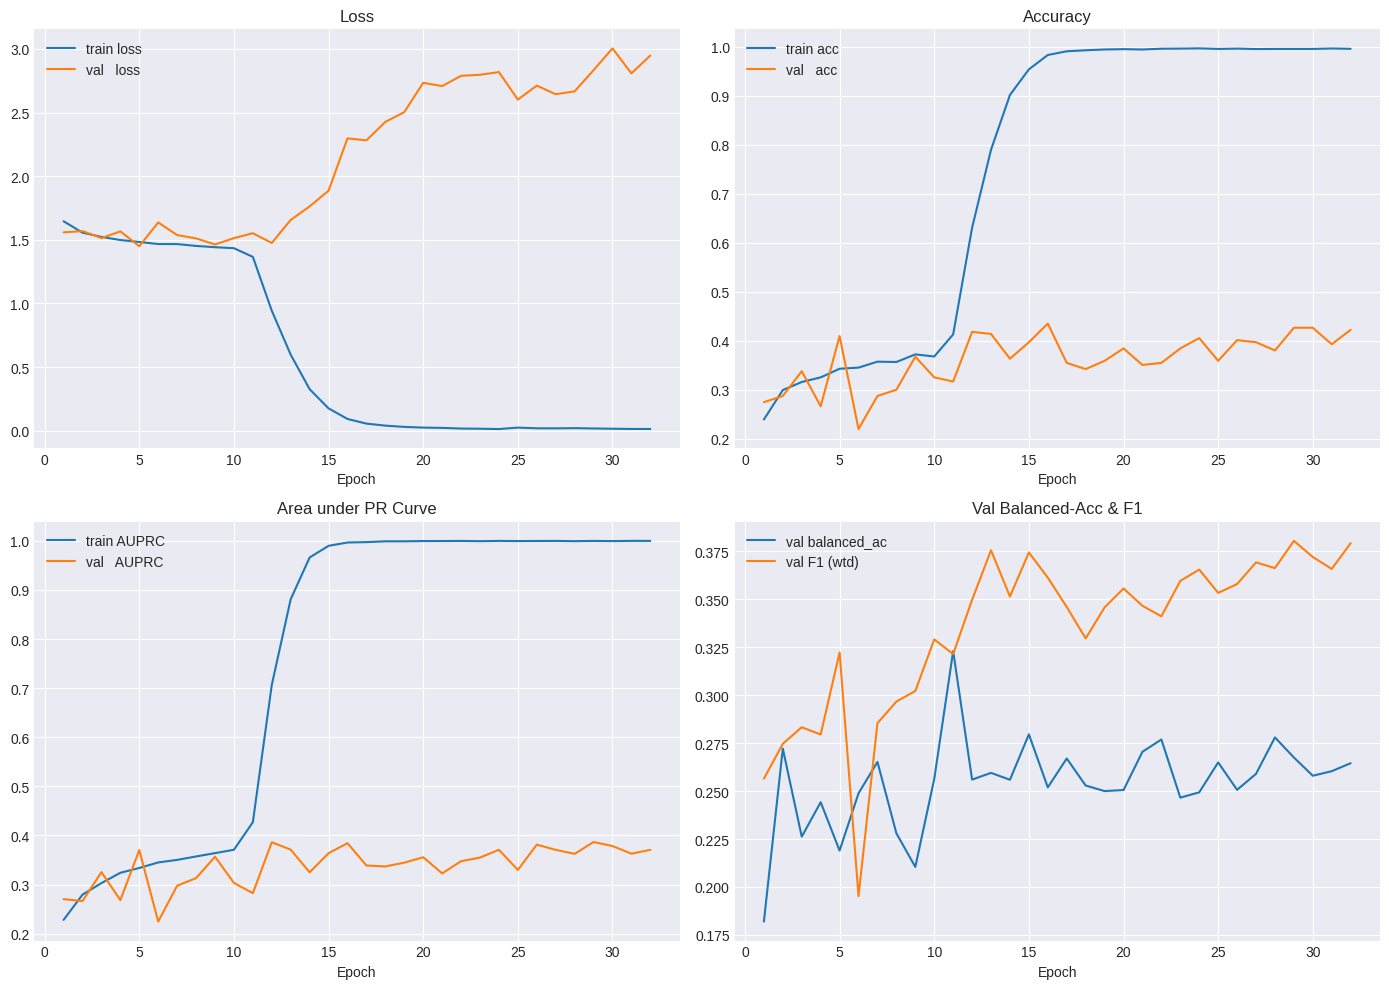

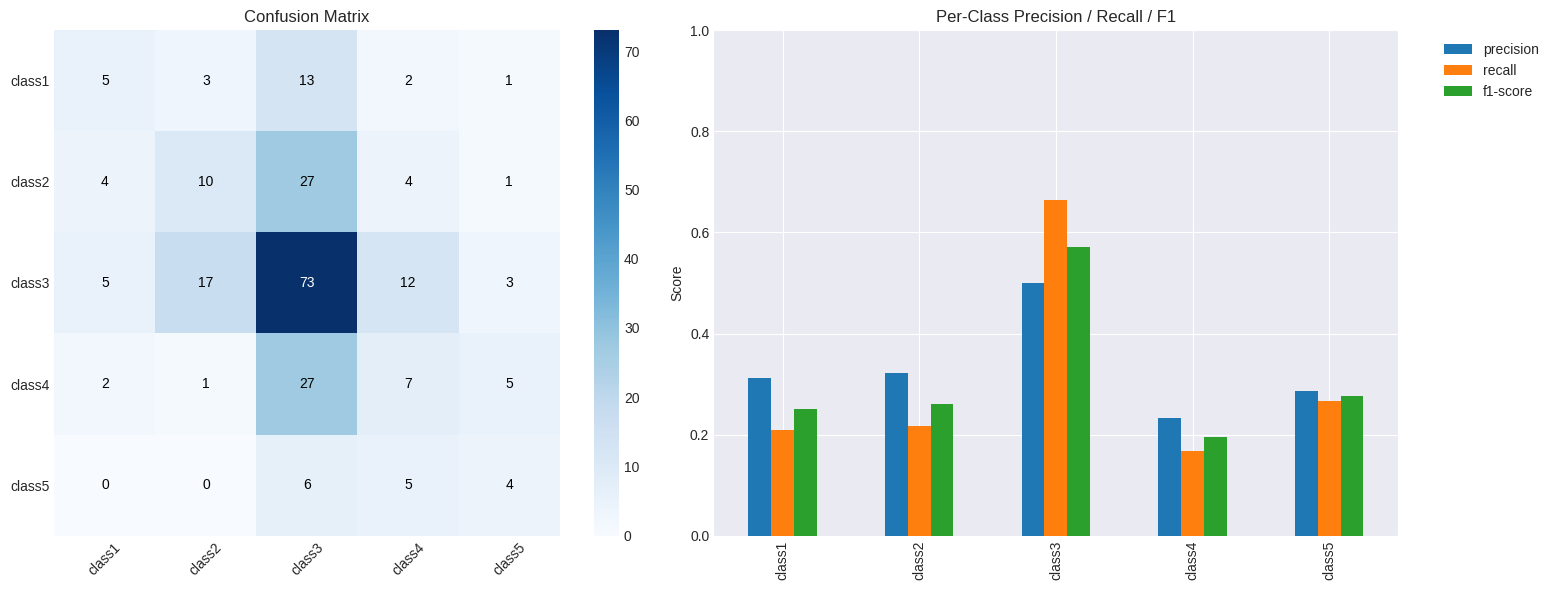


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model1,
    history=history1,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

/tmp/ipykernel_19/3456430793.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


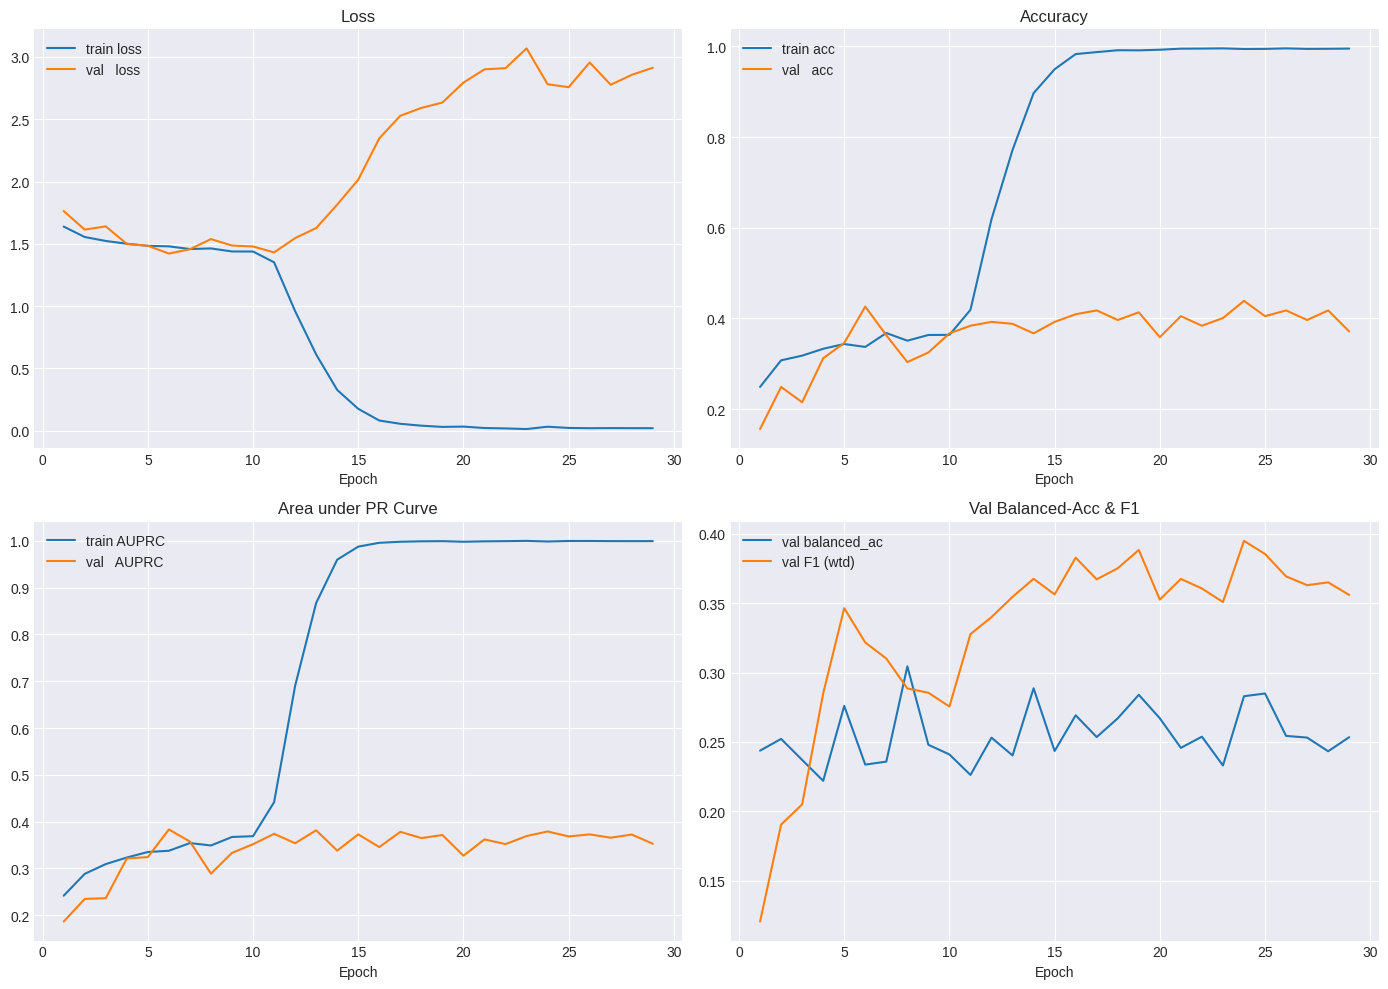

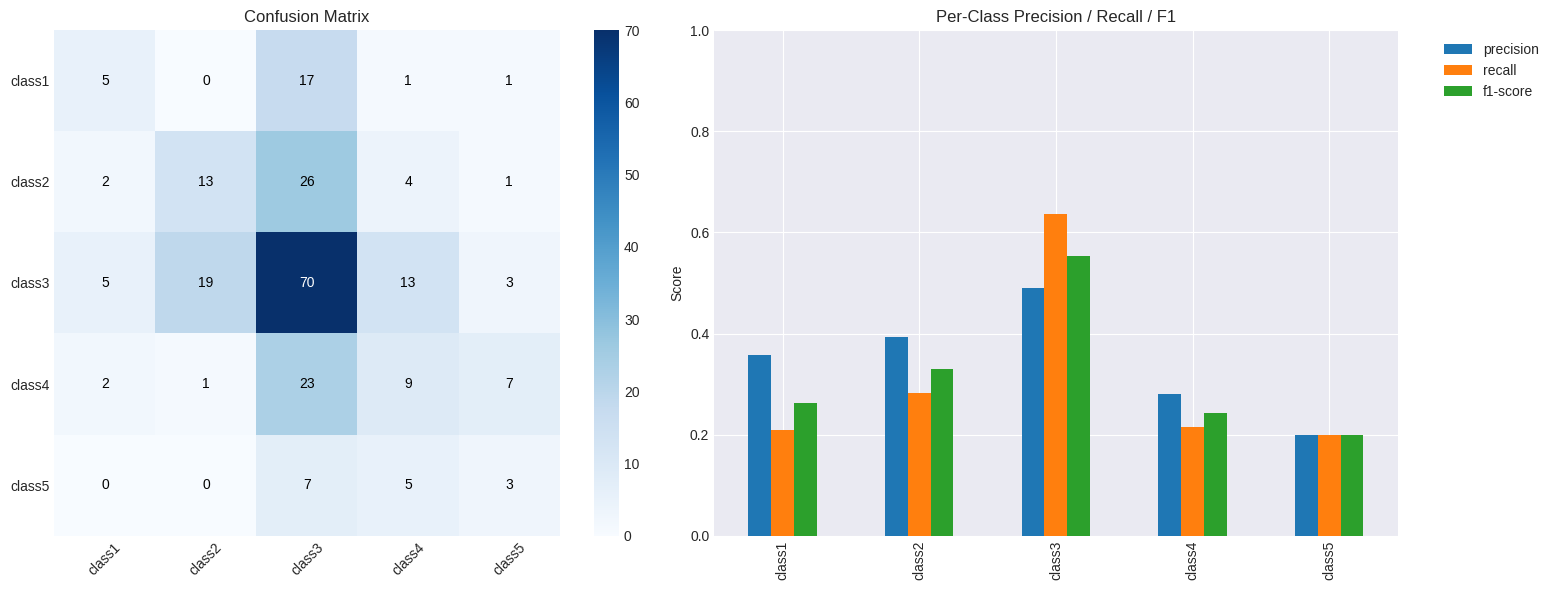


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model2,
    history=history2,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

/tmp/ipykernel_19/3456430793.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


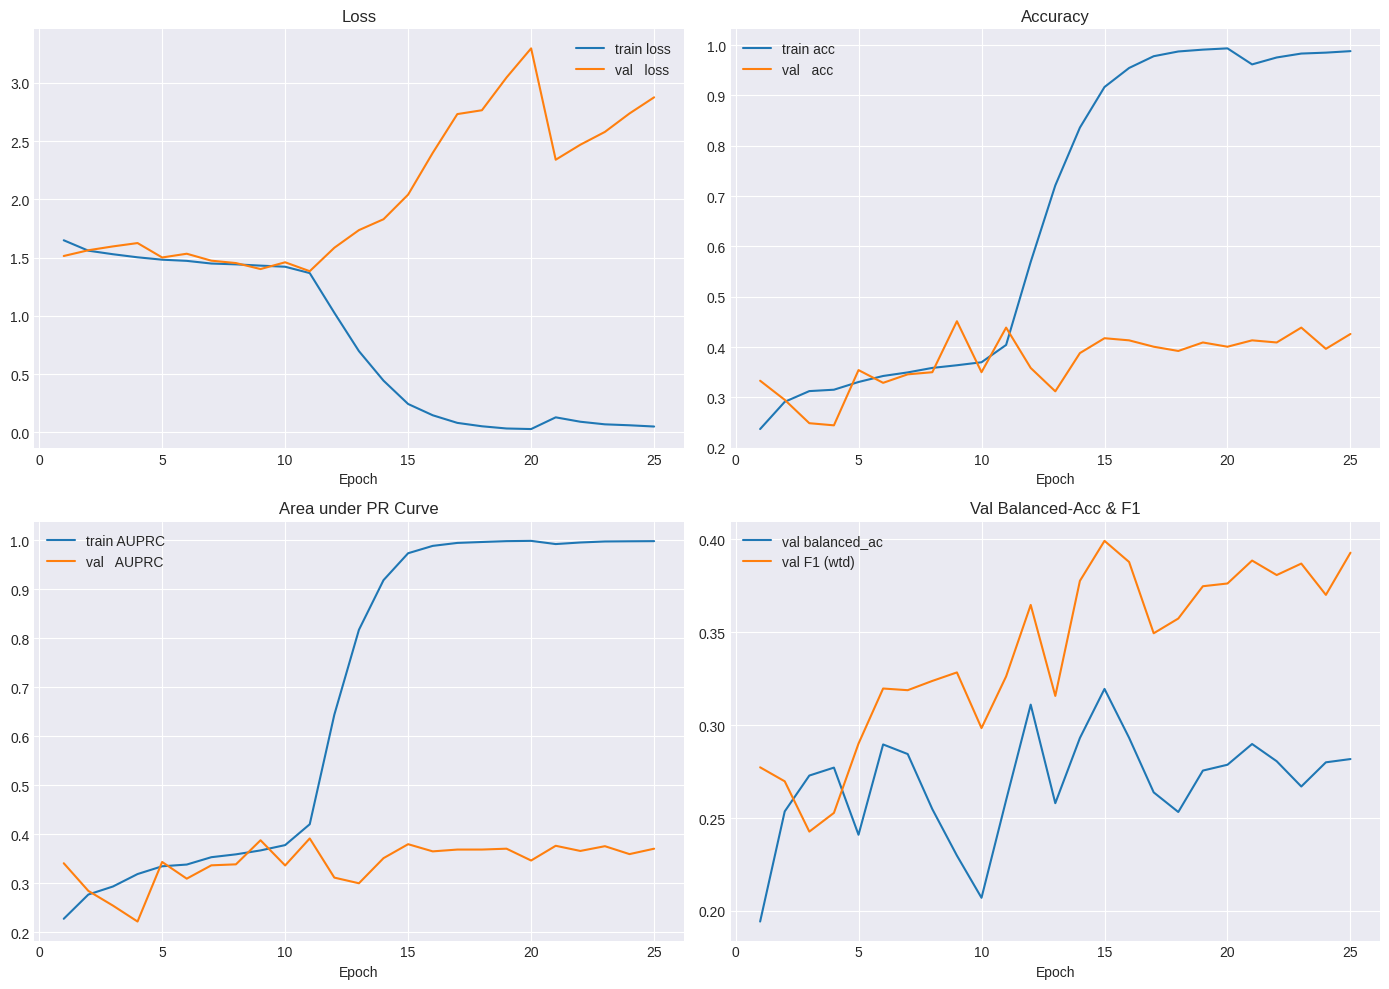

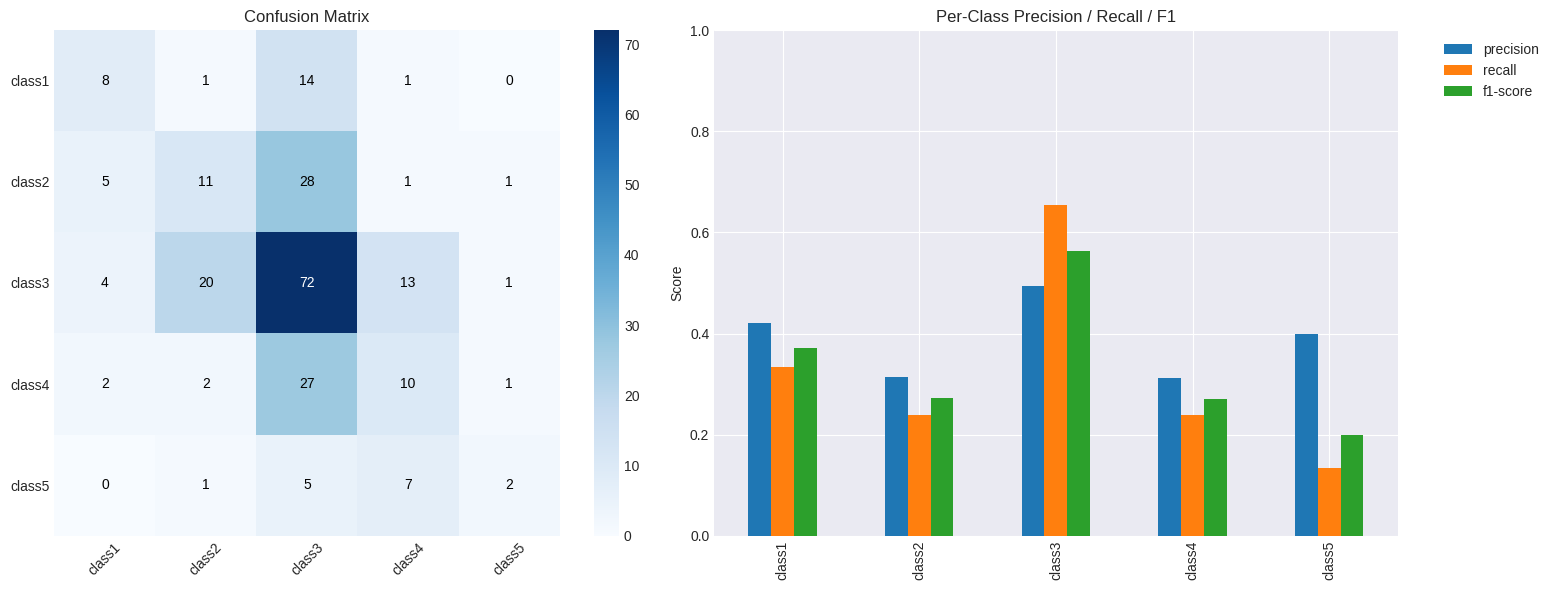


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model3,
    history=history3,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

### Nodule 5

#### Model

In [ ]:
model1, history1 = train_three_stage(
    X_train, y_train, X_val, y_val,
    head_layers=[5],
    batch_size=32,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

model2, history2 = train_three_stage(
    X_train, y_train, X_val, y_val,
    head_layers=[128, 5],
    batch_size=32,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

model3, history3 = train_three_stage(
    X_train, y_train, X_val, y_val,
    head_layers=[256, 128, 5],
    batch_size=32,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

I0000 00:00:1745787311.681059      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

=== Stage 1: Training head only (lr=1e-3) ===
Epoch 1/10


I0000 00:00:1745787331.886514      96 service.cc:148] XLA service 0x7e735000bc00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745787331.887380      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745787333.405868      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/137 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - AUPRC: 0.1718 - accuracy: 0.1406 - loss: 2.5607  

I0000 00:00:1745787338.280439      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - AUPRC: 0.2087 - accuracy: 0.2176 - loss: 1.9454 — val_balanced_accuracy: 0.3819 — val_f1_score: 0.2254 — val_weighted_auprc: 0.4417

Epoch 1: val_weighted_auprc improved from -inf to 0.44168, saving model to best_model_5.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 55s 247ms/step - AUPRC: 0.2089 - accuracy: 0.2178 - loss: 1.9438 - val_AUPRC: 0.2909 - val_accuracy: 0.2574 - val_loss: 1.5205 - val_balanced_accuracy: 0.3819 - val_f1_score: 0.2254 - val_weighted_auprc: 0.4417
Epoch 2/10
136/137 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - AUPRC: 0.3416 - accuracy: 0.3358 - loss: 1.4917 — val_balanced_accuracy: 0.4483 — val_f1_score: 0.3211 — val_weighted_auprc: 0.4691

Epoch 2: val_weighted_auprc improved from 0.44168 to 0.46905, saving model to best_model_5.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - AUPRC: 0.3418 - accuracy: 0.3360 - loss: 1.4914 - val_AUPRC: 0.3480 - val_accuracy: 0.3376 - val_loss: 1.4464 - val_balanced_accuracy: 0.4483 - val_f1_score: 0

E0000 00:00:1745787501.609422      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745787501.804049      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745787502.006330      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745787502.182924      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


136/137 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - AUPRC: 0.5539 - accuracy: 0.5056 - loss: 1.1904

E0000 00:00:1745787534.789368      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745787534.965466      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745787535.203696      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745787535.397978      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - AUPRC: 0.5542 - accuracy: 0.5058 - loss: 1.1898 — val_balanced_accuracy: 0.5505 — val_f1_score: 0.4527 — val_weighted_auprc: 0.5614

Epoch 1: val_weighted_auprc improved from 0.51312 to 0.56143, saving model to best_model_5.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 92s 390ms/step - AUPRC: 0.5545 - accuracy: 0.5060 - loss: 1.1892 - val_AUPRC: 0.5023 - val_accuracy: 0.4557 - val_loss: 1.2245 - val_balanced_accuracy: 0.5505 - val_f1_score: 0.4527 - val_weighted_auprc: 0.5614 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.357142857142858e-05.
Epoch 2/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - AUPRC: 0.7357 - accuracy: 0.6487 - loss: 0.8630 — val_balanced_accuracy: 0.5899 — val_f1_score: 0.5677 — val_weighted_auprc: 0.5798

Epoch 2: val_weighted_auprc improved from 0.56143 to 0.57975, saving model to best_model_5.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - AUPRC: 0.7358 - accuracy: 0.6488 - loss: 0.86

#### Evaluation

/tmp/ipykernel_31/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


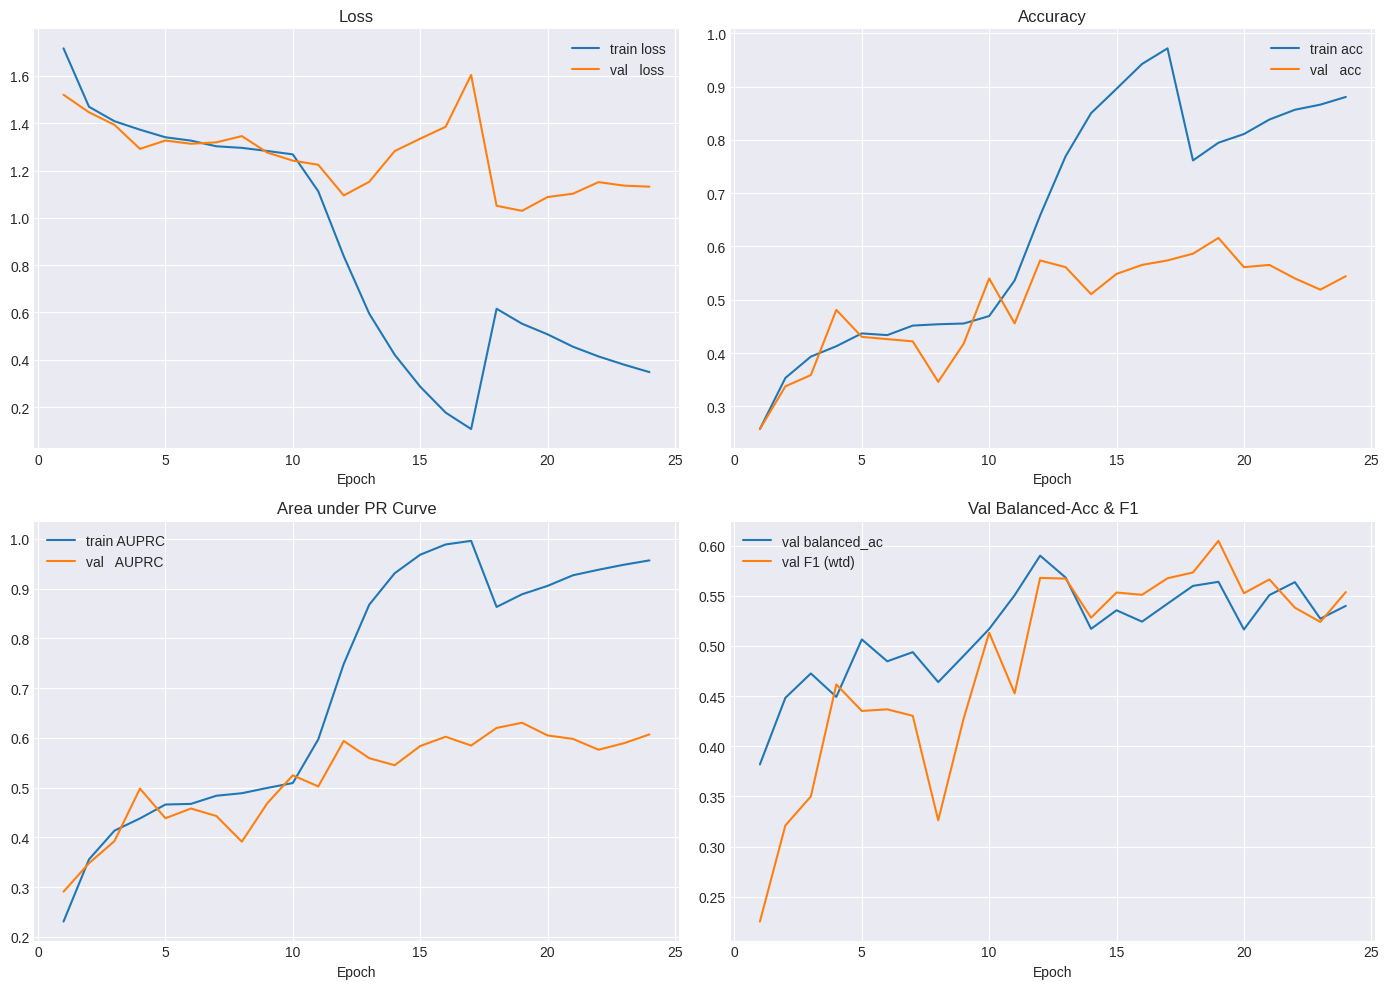

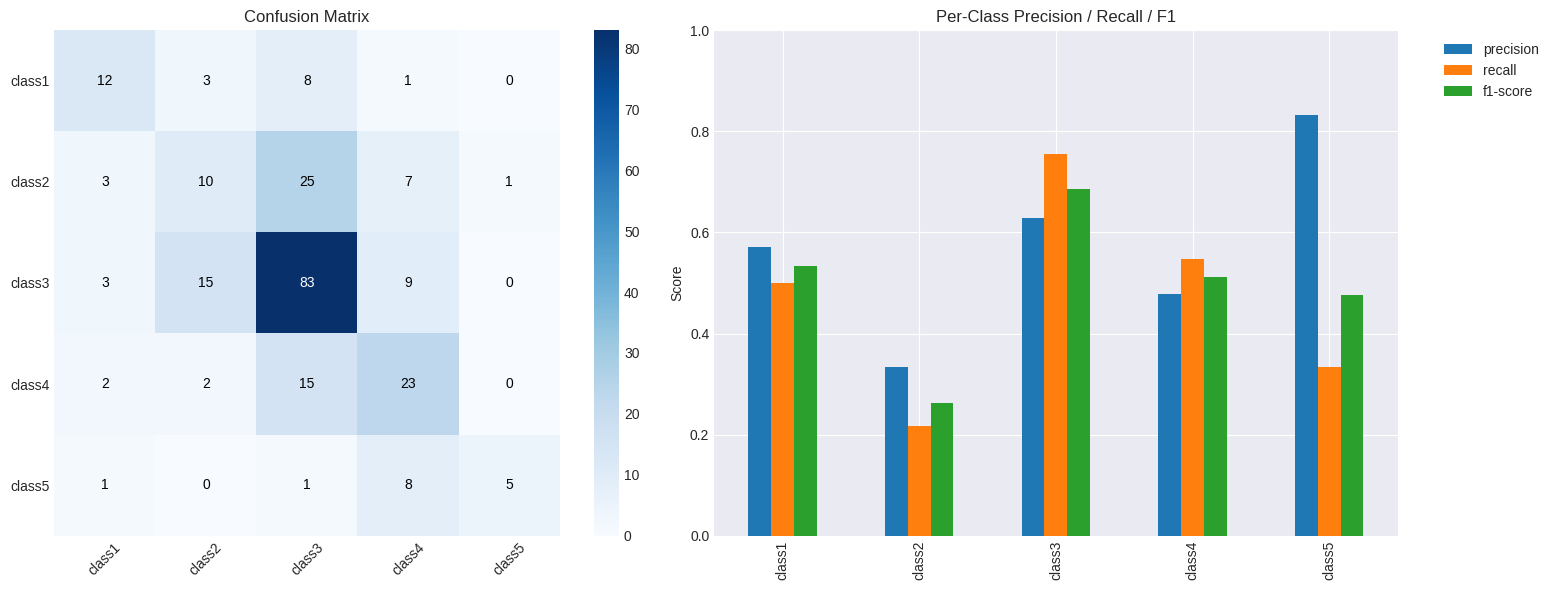


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model1,
    history=history1,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

/tmp/ipykernel_31/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


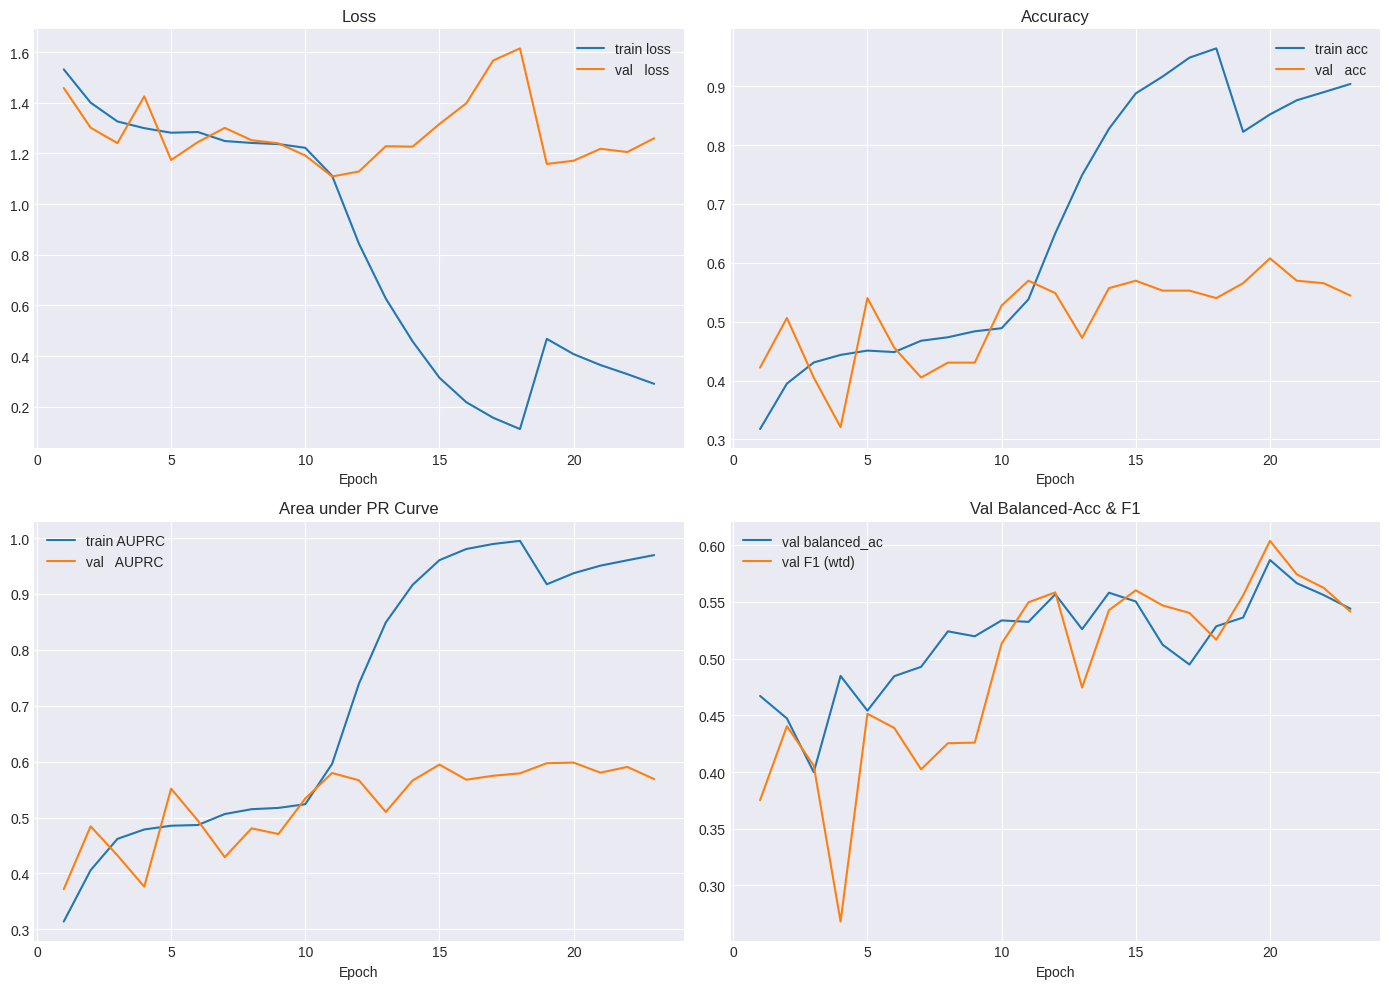

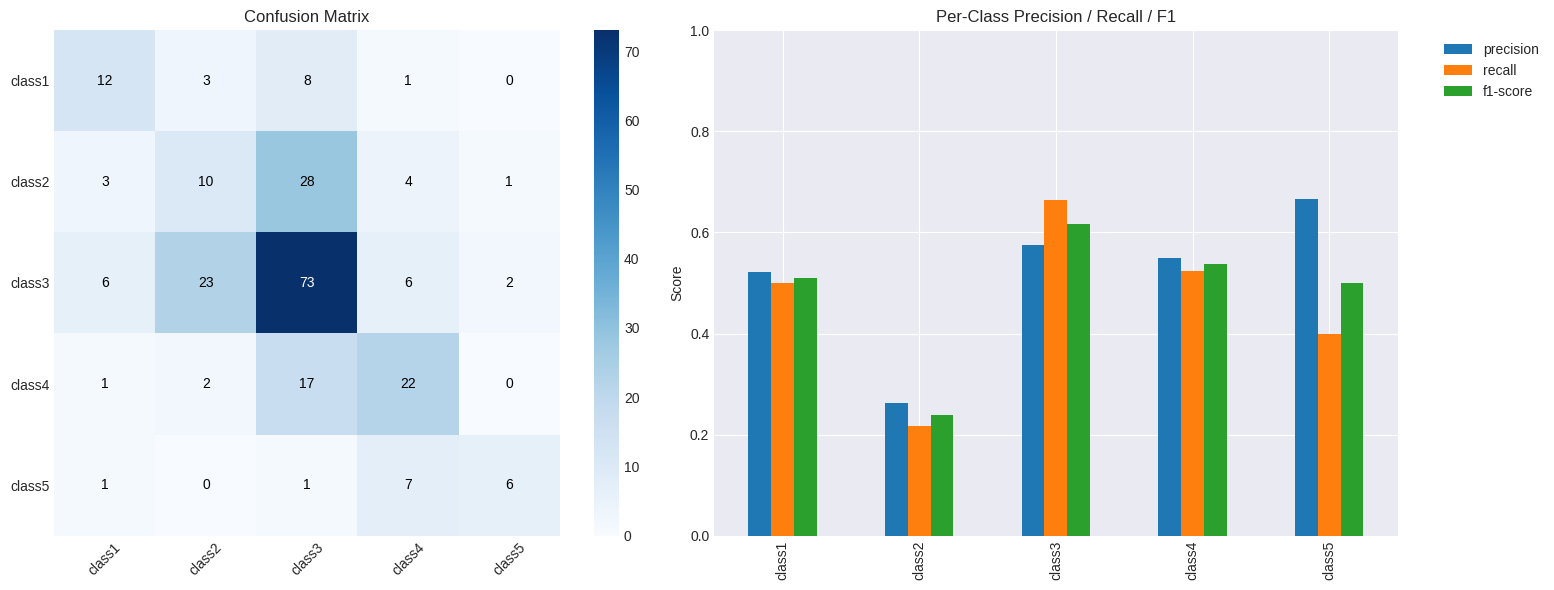


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model2,
    history=history2,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

/tmp/ipykernel_31/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


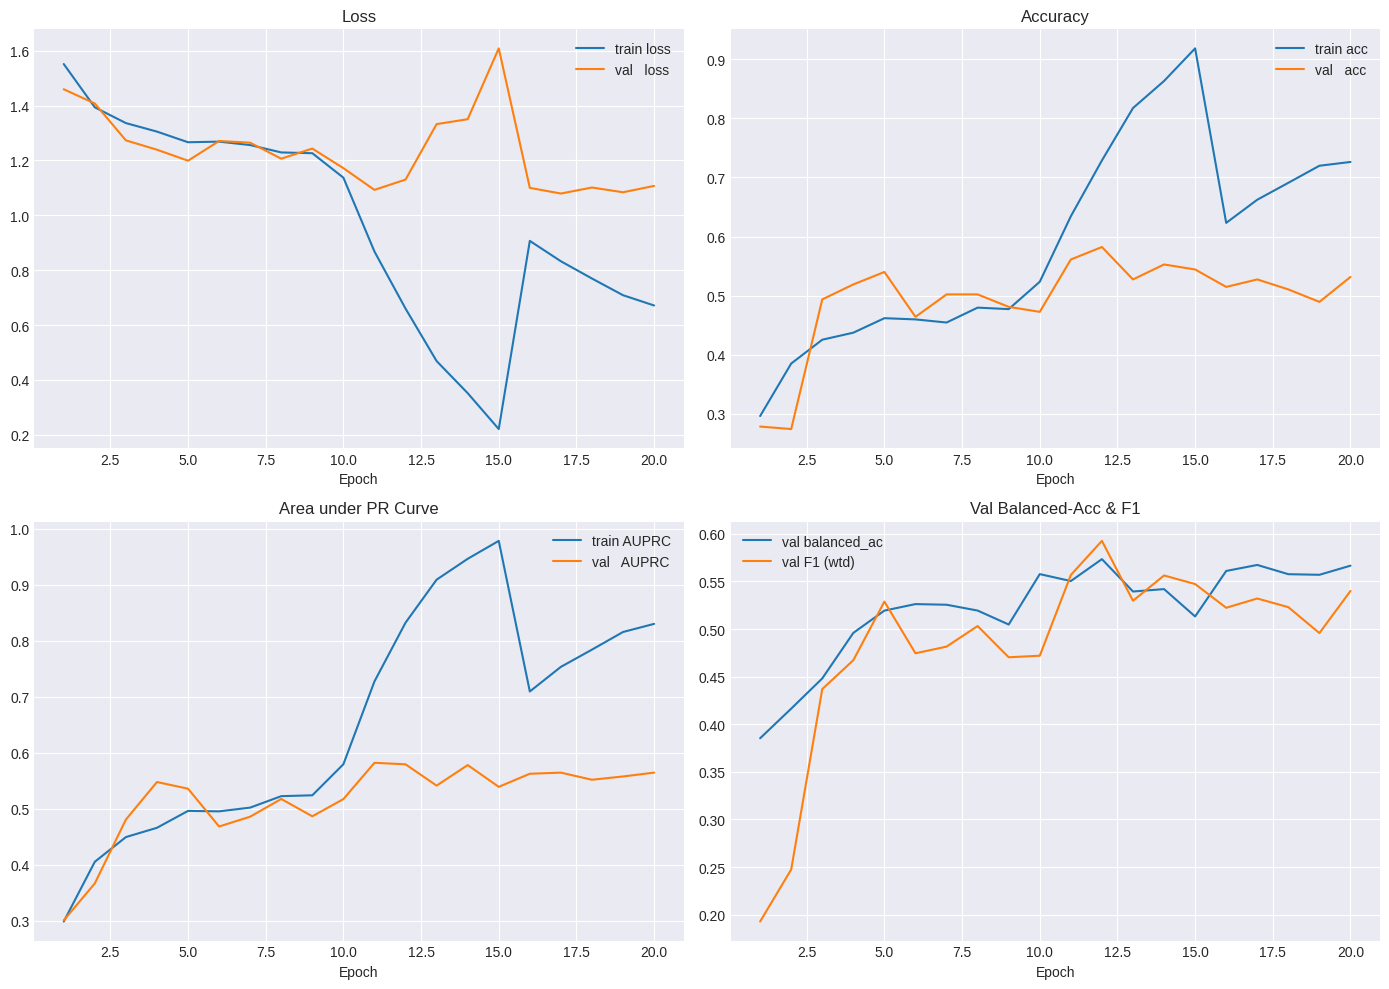

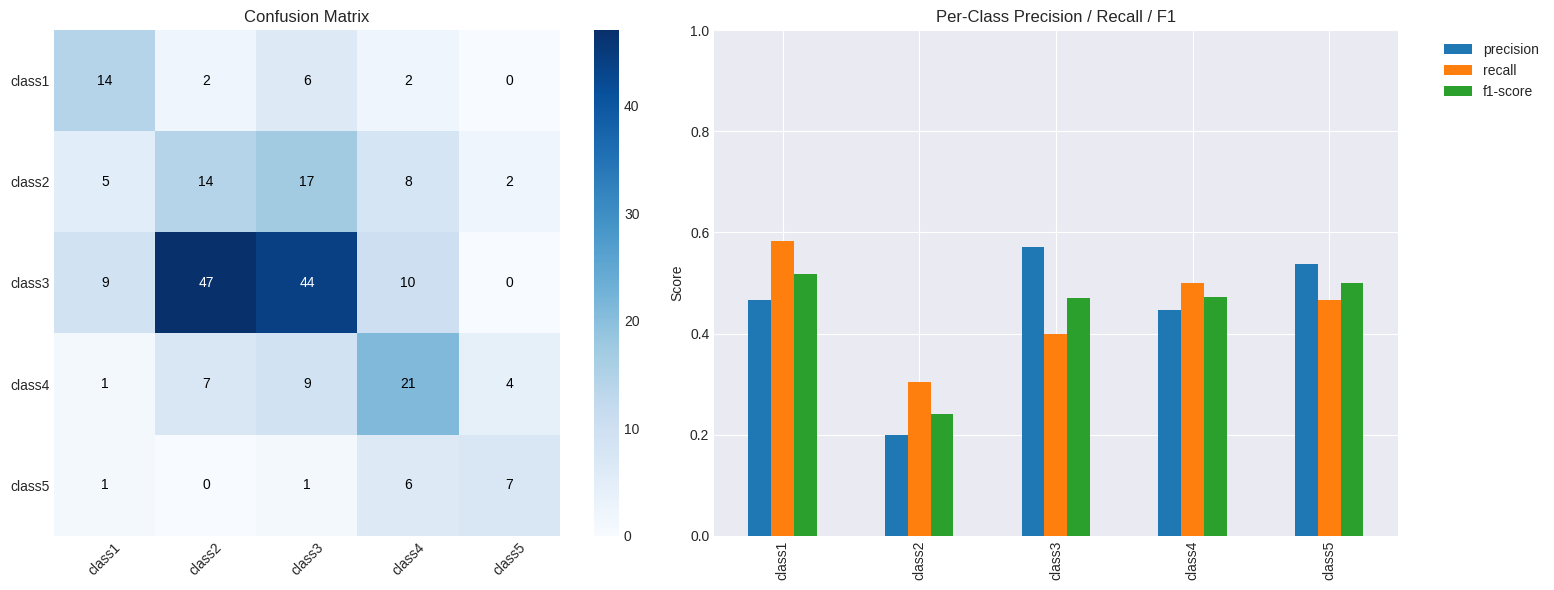


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model3,
    history=history3,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

## Batch Search

### Full 5

#### Model

In [ ]:

def train_three_stage(X_train, y_train, X_val, y_val,
                      batch_size=32,
                      stage1_epochs=10,
                      stage2_epochs=15,
                      stage3_epochs=20):
    train_ds = make_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
    val_ds   = make_dataset(X_val,   y_val,   batch_size=batch_size, shuffle=False)

    model, backbone = build_convnext_classifier()

    metrics_cb = ValidationMetrics(val_ds)
    es = callbacks.EarlyStopping(
        monitor='val_weighted_auprc', mode='max',
        patience=5, restore_best_weights=True, verbose=1
    )
    rlrop = callbacks.ReduceLROnPlateau(
        monitor='val_weighted_auprc', mode='max',
        factor=0.5, patience=3, verbose=1
    )
    ckpt = callbacks.ModelCheckpoint(
        'best_model.keras', monitor='val_weighted_auprc',
        mode='max', save_best_only=True, verbose=1
    )

    history_all = {
        'loss': [], 'accuracy': [], 'AUPRC': [],
        'val_loss': [], 'val_accuracy': [], 'val_AUPRC': [],
        'val_balanced_accuracy': [], 'val_f1_score': [], 'val_weighted_auprc': []
    }

    def _fit(epochs, lr):
        optimizer = optimizers.AdamW(learning_rate=lr)
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.AUC(curve='PR', name='AUPRC')
            ]
        )
        h = model.fit(
            train_ds, validation_data=val_ds,
            epochs=epochs,
            callbacks=[metrics_cb, es, rlrop, ckpt],
            verbose=1
        )
        for k in history_all:
            if k in h.history:
                history_all[k] += h.history[k]
        return h

    # --- Stage 1: train head only ---
    for layer in backbone.layers:
        layer.trainable = False
    for layer in model.layers[len(backbone.layers):]:
        layer.trainable = True
    print("\n=== Stage 1: Training head only ===")
    _fit(stage1_epochs, lr=1e-3)

    # --- Stage 2: fine-tune last 40% of backbone ---
    n = len(backbone.layers)
    k = int(n * 0.4)
    for layer in backbone.layers[: n - k]:
        layer.trainable = False
    for layer in backbone.layers[n - k :]:
        layer.trainable = True
    print("\n=== Stage 2: Fine-tune last 40% of backbone ===")
    _fit(stage2_epochs, lr=1e-4)

    # --- Stage 3: fine-tune whole network ---
    for layer in backbone.layers:
        layer.trainable = True
    print("\n=== Stage 3: Fine-tune whole network ===")
    _fit(stage3_epochs, lr=1e-5)

    np.save('training_history.npy', history_all)
    print("History saved to training_history.npy")

    return model, history_all

In [ ]:
model1, history1 = train_three_stage(
    X_train, y_train, X_val, y_val,
    batch_size=16,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

model2, history2 = train_three_stage(
    X_train, y_train, X_val, y_val,
    batch_size=32,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

model3, history3 = train_three_stage(
    X_train, y_train, X_val, y_val,
    batch_size=64,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

I0000 00:00:1746264633.571405      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

=== Stage 1: Training head only ===
Epoch 1/10


I0000 00:00:1746264653.431404      92 service.cc:148] XLA service 0x7abf40002200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746264653.432266      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746264654.835221      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/273 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUPRC: 0.1893 - accuracy: 0.1971 - loss: 2.6086  

I0000 00:00:1746264659.040324      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - AUPRC: 0.2102 - accuracy: 0.2237 - loss: 1.8333 — val_balanced_accuracy: 0.2047 — val_f1_score: 0.1232 — val_weighted_auprc: 0.3392

Epoch 1: val_weighted_auprc improved from -inf to 0.33925, saving model to best_model.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 54s 126ms/step - AUPRC: 0.2103 - accuracy: 0.2237 - loss: 1.8327 - val_AUPRC: 0.2349 - val_accuracy: 0.1983 - val_loss: 1.5924 - val_balanced_accuracy: 0.2047 - val_f1_score: 0.1232 - val_weighted_auprc: 0.3392 - learning_rate: 0.0010
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUPRC: 0.2655 - accuracy: 0.2784 - loss: 1.5698 — val_balanced_accuracy: 0.2285 — val_f1_score: 0.3053 — val_weighted_auprc: 0.3472

Epoch 2: val_weighted_auprc improved from 0.33925 to 0.34717, saving model to best_model.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - AUPRC: 0.2655 - accuracy: 0.2785 - loss: 1.5697 - val_AUPRC: 0.3355 - val_accuracy: 0.3460 - val_loss: 1.4939 - val_balanced_accuracy: 0.22

E0000 00:00:1746264831.477125      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746264831.652791      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746264831.895879      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746264832.090470      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


272/273 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUPRC: 0.3713 - accuracy: 0.3766 - loss: 1.4423

E0000 00:00:1746264866.382018      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746264866.557902      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746264866.794974      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746264866.989080      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - AUPRC: 0.3715 - accuracy: 0.3767 - loss: 1.4421 — val_balanced_accuracy: 0.2261 — val_f1_score: 0.3246 — val_weighted_auprc: 0.3476

Epoch 1: val_weighted_auprc did not improve from 0.35644
273/273 ━━━━━━━━━━━━━━━━━━━━ 91s 194ms/step - AUPRC: 0.3717 - accuracy: 0.3768 - loss: 1.4418 - val_AUPRC: 0.3618 - val_accuracy: 0.3713 - val_loss: 1.4325 - val_balanced_accuracy: 0.2261 - val_f1_score: 0.3246 - val_weighted_auprc: 0.3476 - learning_rate: 1.0000e-04
Epoch 2/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUPRC: 0.6799 - accuracy: 0.6053 - loss: 0.9973 — val_balanced_accuracy: 0.2648 — val_f1_score: 0.3480 — val_weighted_auprc: 0.3547

Epoch 2: val_weighted_auprc did not improve from 0.35644
273/273 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - AUPRC: 0.6800 - accuracy: 0.6053 - loss: 0.9972 - val_AUPRC: 0.3313 - val_accuracy: 0.3544 - val_loss: 1.5451 - val_balanced_accuracy: 0.2648 - val_f1_score: 0.3480 - val_weighted_auprc: 0.3547 - learning_ra

E0000 00:00:1746265652.719999      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746265652.914791      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746265653.100853      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746265653.277528      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - AUPRC: 0.3280 - accuracy: 0.3452 - loss: 1.4954 — val_balanced_accuracy: 0.2336 — val_f1_score: 0.3005 — val_weighted_auprc: 0.3371

Epoch 1: val_weighted_auprc did not improve from 0.35544
137/137 ━━━━━━━━━━━━━━━━━━━━ 88s 356ms/step - AUPRC: 0.3283 - accuracy: 0.3454 - loss: 1.4949 - val_AUPRC: 0.3113 - val_accuracy: 0.3038 - val_loss: 1.5199 - val_balanced_accuracy: 0.2336 - val_f1_score: 0.3005 - val_weighted_auprc: 0.3371 - learning_rate: 1.0000e-04
Epoch 2/15
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - AUPRC: 0.5655 - accuracy: 0.5316 - loss: 1.1764 — val_balanced_accuracy: 0.2925 — val_f1_score: 0.3301 — val_weighted_auprc: 0.3454

Epoch 2: val_weighted_auprc did not improve from 0.35544
137/137 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - AUPRC: 0.5657 - accuracy: 0.5317 - loss: 1.1761 - val_AUPRC: 0.3206 - val_accuracy: 0.3544 - val_loss: 1.5062 - val_balanced_accuracy: 0.2925 - val_f1_score: 0.3301 - val_weighted_auprc: 0.3454 - learning_

E0000 00:00:1746266422.457252      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746266422.634459      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746266422.883072      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746266423.080545      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - AUPRC: 0.3489 - accuracy: 0.3624 - loss: 1.4617 — val_balanced_accuracy: 0.2145 — val_f1_score: 0.3177 — val_weighted_auprc: 0.3514

Epoch 1: val_weighted_auprc improved from 0.34598 to 0.35144, saving model to best_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 92s 734ms/step - AUPRC: 0.3494 - accuracy: 0.3627 - loss: 1.4611 - val_AUPRC: 0.3799 - val_accuracy: 0.3797 - val_loss: 1.4332 - val_balanced_accuracy: 0.2145 - val_f1_score: 0.3177 - val_weighted_auprc: 0.3514 - learning_rate: 1.0000e-04
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - AUPRC: 0.5243 - accuracy: 0.5041 - loss: 1.2343 — val_balanced_accuracy: 0.3061 — val_f1_score: 0.3559 — val_weighted_auprc: 0.3641

Epoch 2: val_weighted_auprc improved from 0.35144 to 0.36407, saving model to best_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 337ms/step - AUPRC: 0.5250 - accuracy: 0.5045 - loss: 1.2334 - val_AUPRC: 0.3639 - val_accuracy: 0.3840 - val_loss: 1.4456 - val_balanced_accuracy: 0.

#### Evaluation

/tmp/ipykernel_31/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


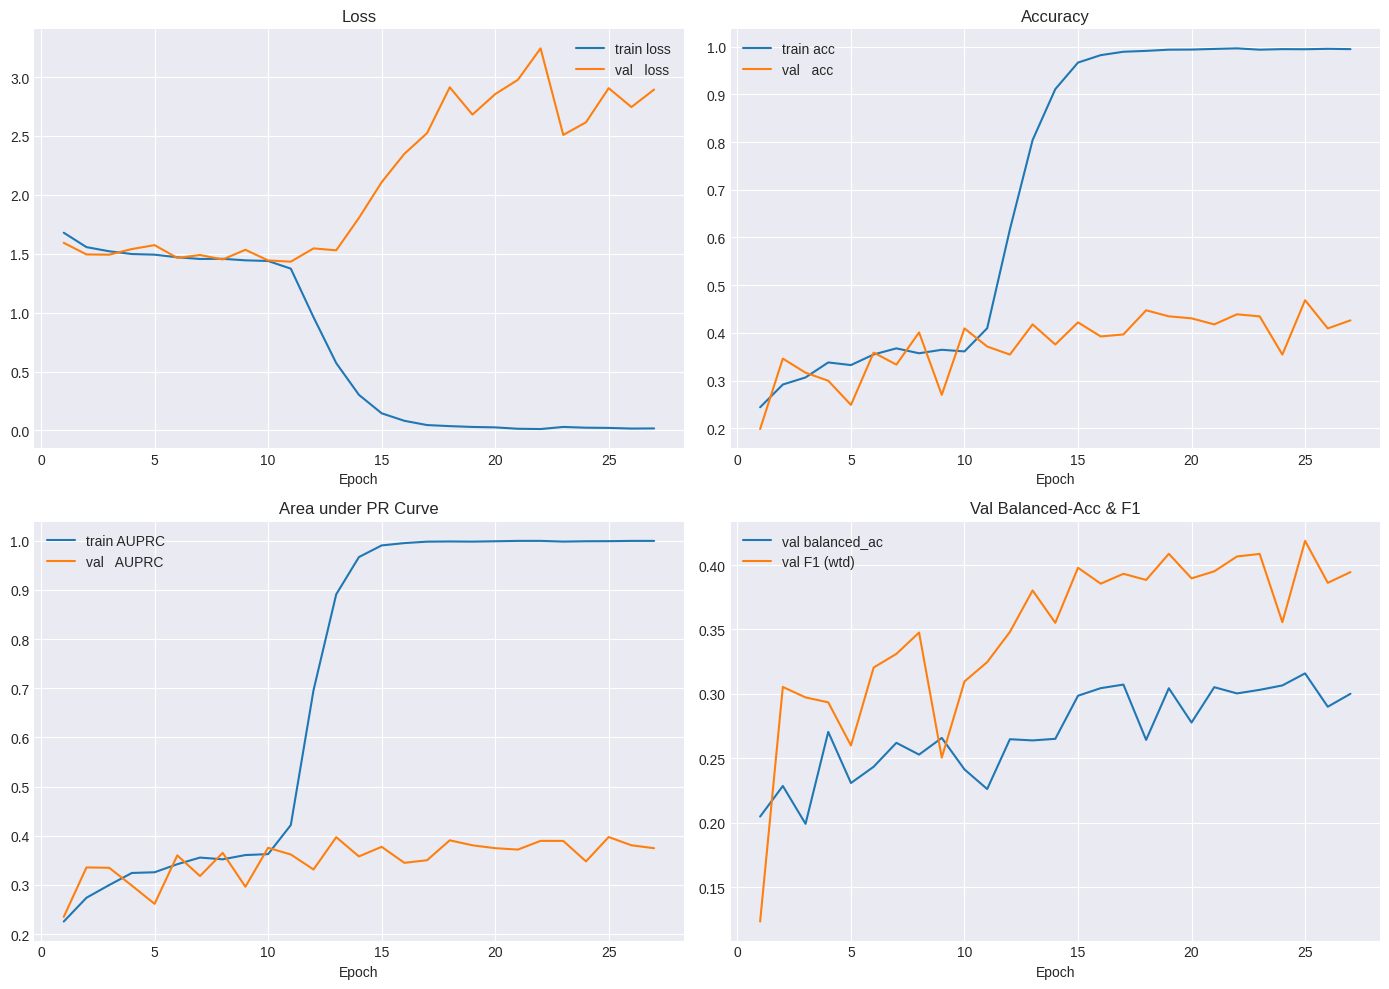

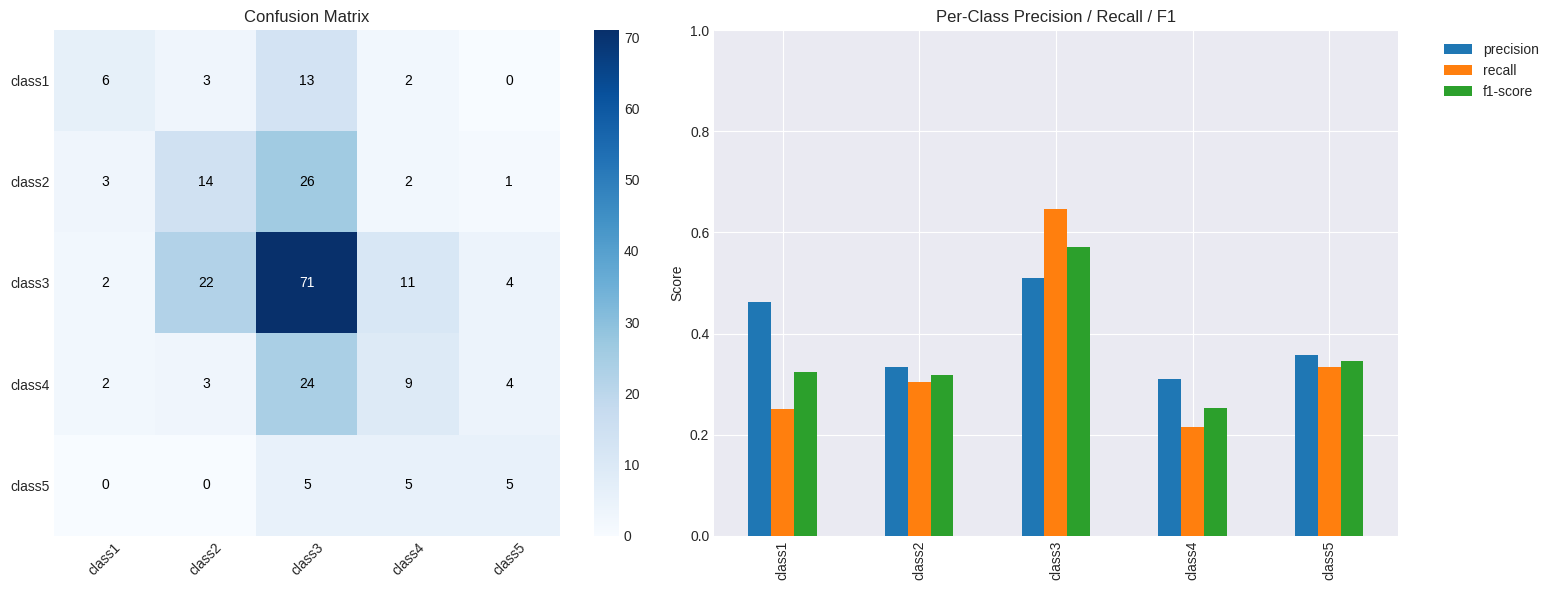


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model1,
    history=history1,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

/tmp/ipykernel_31/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


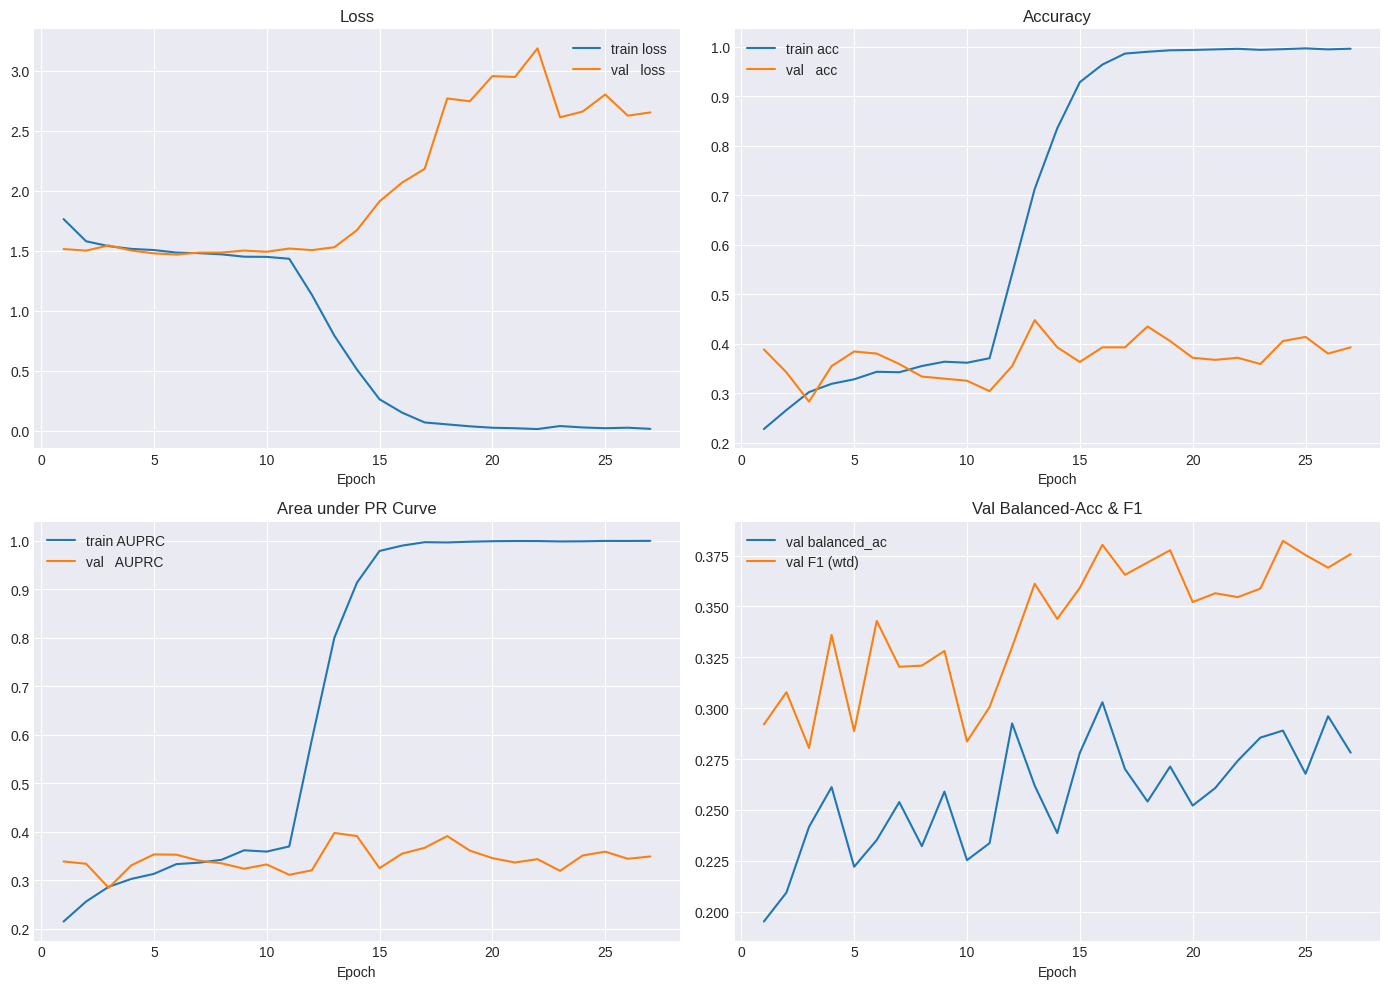

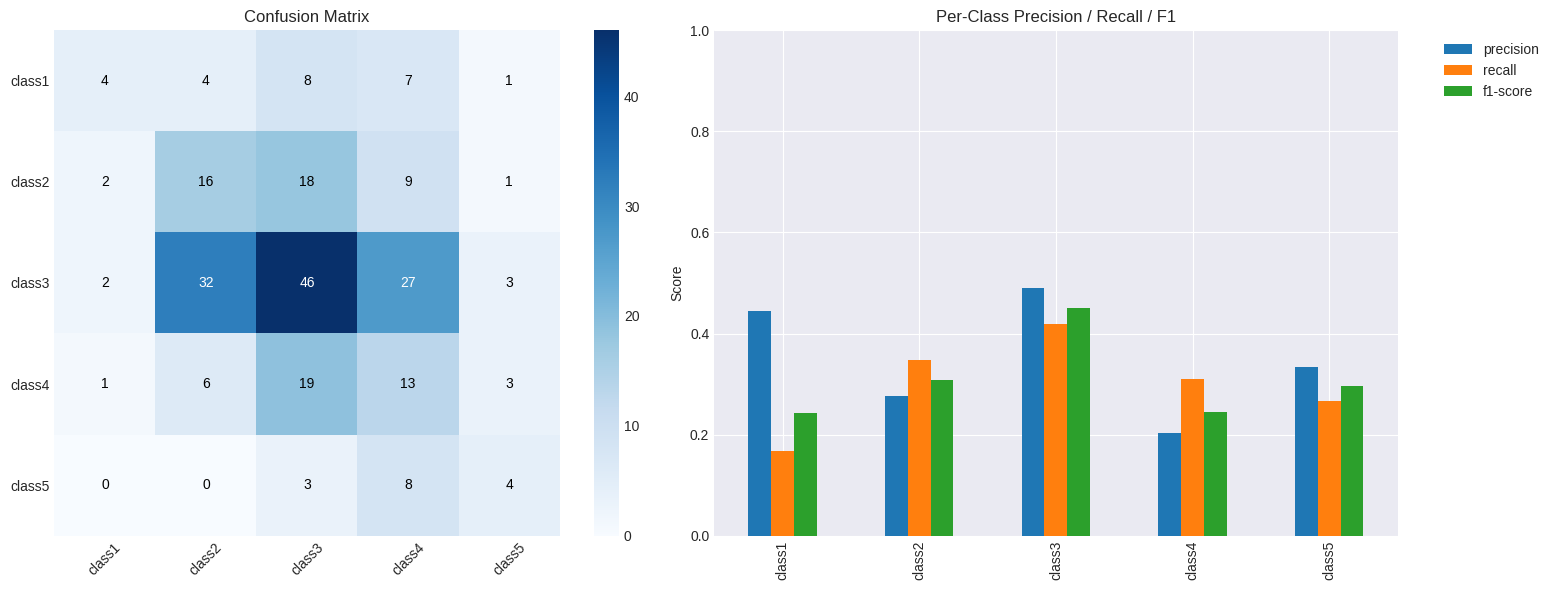


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model2,
    history=history2,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

/tmp/ipykernel_31/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


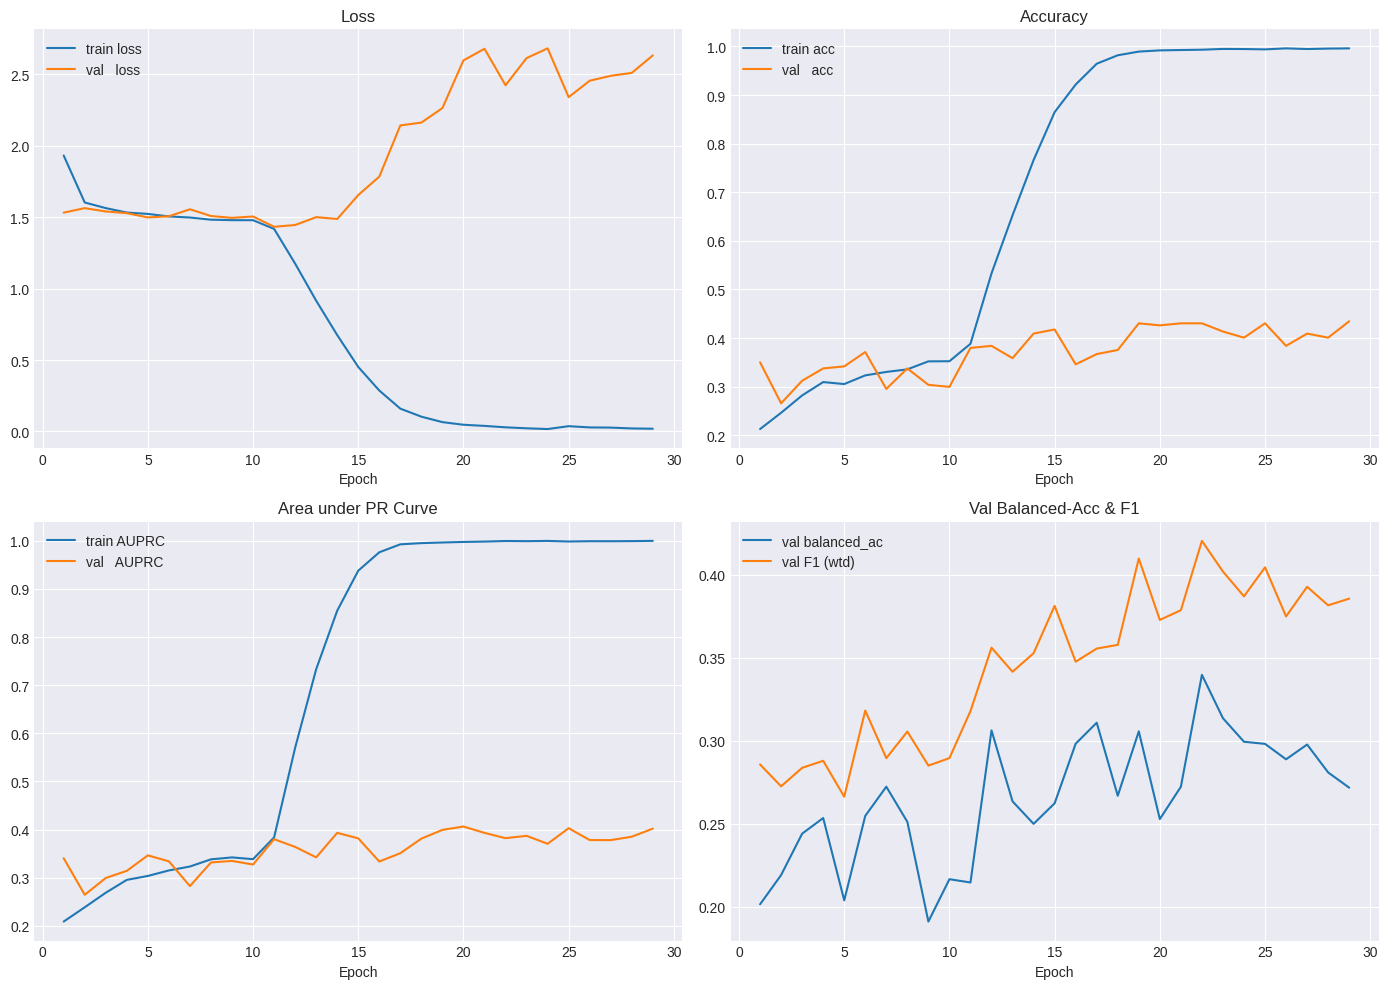

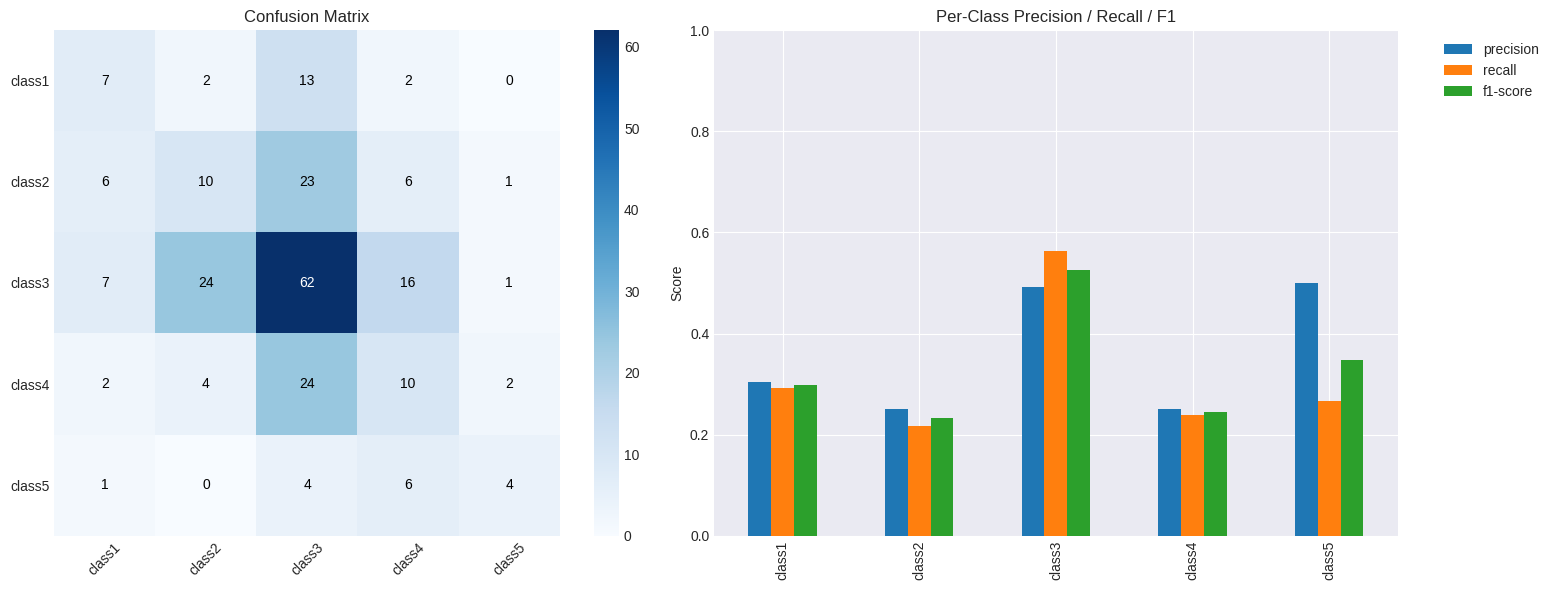


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model3,
    history=history3,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

evaluate_model(
    model=model2,
    history=history2,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

evaluate_model(
    model=model3,
    history=history3,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

### Nodule 5

#### Model

In [ ]:
def train_three_stage(X_train, y_train, X_val, y_val,
                      batch_size=32,
                      stage1_epochs=10,
                      stage2_epochs=15,
                      stage3_epochs=20):
    train_ds = make_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
    val_ds   = make_dataset(X_val,   y_val,   batch_size=batch_size, shuffle=False)

    model, backbone = build_convnext_classifier()

    metrics_cb = ValidationMetrics(val_ds)
    es = callbacks.EarlyStopping(
        monitor='val_weighted_auprc', mode='max',
        patience=5, restore_best_weights=True, verbose=1
    )
    rlrop = callbacks.ReduceLROnPlateau(
        monitor='val_weighted_auprc', mode='max',
        factor=0.5, patience=3, verbose=1
    )
    ckpt = callbacks.ModelCheckpoint(
        'best_model.keras', monitor='val_weighted_auprc',
        mode='max', save_best_only=True, verbose=1
    )

    history_all = {
        'loss': [], 'accuracy': [], 'AUPRC': [],
        'val_loss': [], 'val_accuracy': [], 'val_AUPRC': [],
        'val_balanced_accuracy': [], 'val_f1_score': [], 'val_weighted_auprc': []
    }

    def _fit(epochs, lr):
        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.AUC(curve='PR', name='AUPRC')
            ]
        )
        h = model.fit(
            train_ds, validation_data=val_ds,
            epochs=epochs,
            callbacks=[metrics_cb, es, rlrop, ckpt],
            verbose=1
        )
        for k in history_all:
            if k in h.history:
                history_all[k] += h.history[k]
        return h

    # --- Stage 1: train head only ---
    for layer in backbone.layers:
        layer.trainable = False
    for layer in model.layers[len(backbone.layers):]:
        layer.trainable = True
    print("\n=== Stage 1: Training head only ===")
    _fit(stage1_epochs, lr=1e-3)

    # --- Stage 2: fine-tune last 40% of backbone ---
    n = len(backbone.layers)
    k = int(n * 0.4)
    for layer in backbone.layers[: n - k]:
        layer.trainable = False
    for layer in backbone.layers[n - k :]:
        layer.trainable = True
    print("\n=== Stage 2: Fine-tune last 40% of backbone ===")
    _fit(stage2_epochs, lr=1e-4)

    # --- Stage 3: fine-tune whole network ---
    for layer in backbone.layers:
        layer.trainable = True
    print("\n=== Stage 3: Fine-tune whole network ===")
    _fit(stage3_epochs, lr=1e-5)

    np.save('training_history.npy', history_all)
    print("History saved to training_history.npy")

    return model, history_all

In [ ]:
model1, history1 = train_three_stage(
    X_train, y_train, X_val, y_val,
    batch_size=16,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

model2, history2 = train_three_stage(
    X_train, y_train, X_val, y_val,
    batch_size=32,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

model3, history3 = train_three_stage(
    X_train, y_train, X_val, y_val,
    batch_size=64,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

I0000 00:00:1745767587.169112      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

=== Stage 1: Training head only ===
Epoch 1/10


I0000 00:00:1745767609.508975      59 service.cc:148] XLA service 0x7b00d4002390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745767609.510052      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745767610.985668      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/239 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - AUPRC: 0.1908 - accuracy: 0.2027 - loss: 2.4760

I0000 00:00:1745767615.285742      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - AUPRC: 0.2235 - accuracy: 0.2361 - loss: 1.8181 — val_balanced_accuracy: 0.3268 — val_f1_score: 0.2006 — val_weighted_auprc: 0.3985

Epoch 1: val_weighted_auprc improved from -inf to 0.39851, saving model to best_model.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 54s 140ms/step - AUPRC: 0.2237 - accuracy: 0.2363 - loss: 1.8174 - val_AUPRC: 0.2708 - val_accuracy: 0.2489 - val_loss: 1.5041 - val_balanced_accuracy: 0.3268 - val_f1_score: 0.2006 - val_weighted_auprc: 0.3985 - learning_rate: 0.0010
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUPRC: 0.3779 - accuracy: 0.3780 - loss: 1.4477 — val_balanced_accuracy: 0.3372 — val_f1_score: 0.2223 — val_weighted_auprc: 0.4088

Epoch 2: val_weighted_auprc improved from 0.39851 to 0.40881, saving model to best_model.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - AUPRC: 0.3780 - accuracy: 0.3781 - loss: 1.4476 - val_AUPRC: 0.2771 - val_accuracy: 0.2278 - val_loss: 1.4915 - val_balanced_accuracy: 0.33

E0000 00:00:1745767777.013007      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745767777.188910      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745767777.429255      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745767777.623669      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUPRC: 0.5733 - accuracy: 0.5216 - loss: 1.1625

E0000 00:00:1745767809.460035      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745767809.636003      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745767809.861881      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745767810.056181      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - AUPRC: 0.5735 - accuracy: 0.5217 - loss: 1.1621 — val_balanced_accuracy: 0.5017 — val_f1_score: 0.4045 — val_weighted_auprc: 0.5143

Epoch 1: val_weighted_auprc improved from 0.44945 to 0.51429, saving model to best_model.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 91s 222ms/step - AUPRC: 0.5737 - accuracy: 0.5218 - loss: 1.1617 - val_AUPRC: 0.4510 - val_accuracy: 0.4051 - val_loss: 1.2417 - val_balanced_accuracy: 0.5017 - val_f1_score: 0.4045 - val_weighted_auprc: 0.5143 - learning_rate: 1.0000e-04
Epoch 2/15
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUPRC: 0.7893 - accuracy: 0.7016 - loss: 0.7467 — val_balanced_accuracy: 0.4929 — val_f1_score: 0.3922 — val_weighted_auprc: 0.5162

Epoch 2: val_weighted_auprc improved from 0.51429 to 0.51622, saving model to best_model.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - AUPRC: 0.7893 - accuracy: 0.7017 - loss: 0.7466 - val_AUPRC: 0.4428 - val_accuracy: 0.4008 - val_loss: 1.3420 - val_balanced_accur

E0000 00:00:1745768508.094360      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745768508.289232      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745768508.475387      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745768508.651987      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - AUPRC: 0.5520 - accuracy: 0.5065 - loss: 1.1825 — val_balanced_accuracy: 0.4583 — val_f1_score: 0.4773 — val_weighted_auprc: 0.5154

Epoch 1: val_weighted_auprc improved from 0.43787 to 0.51535, saving model to best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 87s 408ms/step - AUPRC: 0.5525 - accuracy: 0.5068 - loss: 1.1818 - val_AUPRC: 0.5364 - val_accuracy: 0.5021 - val_loss: 1.1307 - val_balanced_accuracy: 0.4583 - val_f1_score: 0.4773 - val_weighted_auprc: 0.5154 - learning_rate: 1.0000e-04
Epoch 2/15
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - AUPRC: 0.7620 - accuracy: 0.6738 - loss: 0.8227 — val_balanced_accuracy: 0.4631 — val_f1_score: 0.5205 — val_weighted_auprc: 0.5293

Epoch 2: val_weighted_auprc improved from 0.51535 to 0.52932, saving model to best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - AUPRC: 0.7623 - accuracy: 0.6740 - loss: 0.8220 - val_AUPRC: 0.5581 - val_accuracy: 0.5443 - val_loss: 1.1213 - val_balanced_accu

E0000 00:00:1745769175.130270      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745769175.307618      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745769175.555318      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745769175.752108      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - AUPRC: 0.5616 - accuracy: 0.5210 - loss: 1.1738

E0000 00:00:1745769207.478442      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745769207.674163      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745769207.861277      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745769208.039755      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - AUPRC: 0.5623 - accuracy: 0.5214 - loss: 1.1727 — val_balanced_accuracy: 0.4972 — val_f1_score: 0.5132 — val_weighted_auprc: 0.5417

Epoch 1: val_weighted_auprc improved from 0.43762 to 0.54173, saving model to best_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 852ms/step - AUPRC: 0.5629 - accuracy: 0.5218 - loss: 1.1716 - val_AUPRC: 0.5681 - val_accuracy: 0.5570 - val_loss: 1.0973 - val_balanced_accuracy: 0.4972 - val_f1_score: 0.5132 - val_weighted_auprc: 0.5417 - learning_rate: 1.0000e-04
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - AUPRC: 0.7265 - accuracy: 0.6450 - loss: 0.8823 — val_balanced_accuracy: 0.5043 — val_f1_score: 0.5218 — val_weighted_auprc: 0.5468

Epoch 2: val_weighted_auprc improved from 0.54173 to 0.54685, saving model to best_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 346ms/step - AUPRC: 0.7269 - accuracy: 0.6453 - loss: 0.8817 - val_AUPRC: 0.5813 - val_accuracy: 0.5316 - val_loss: 1.0897 - val_balanced_accuracy: 0.

#### Evaluation

/tmp/ipykernel_19/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


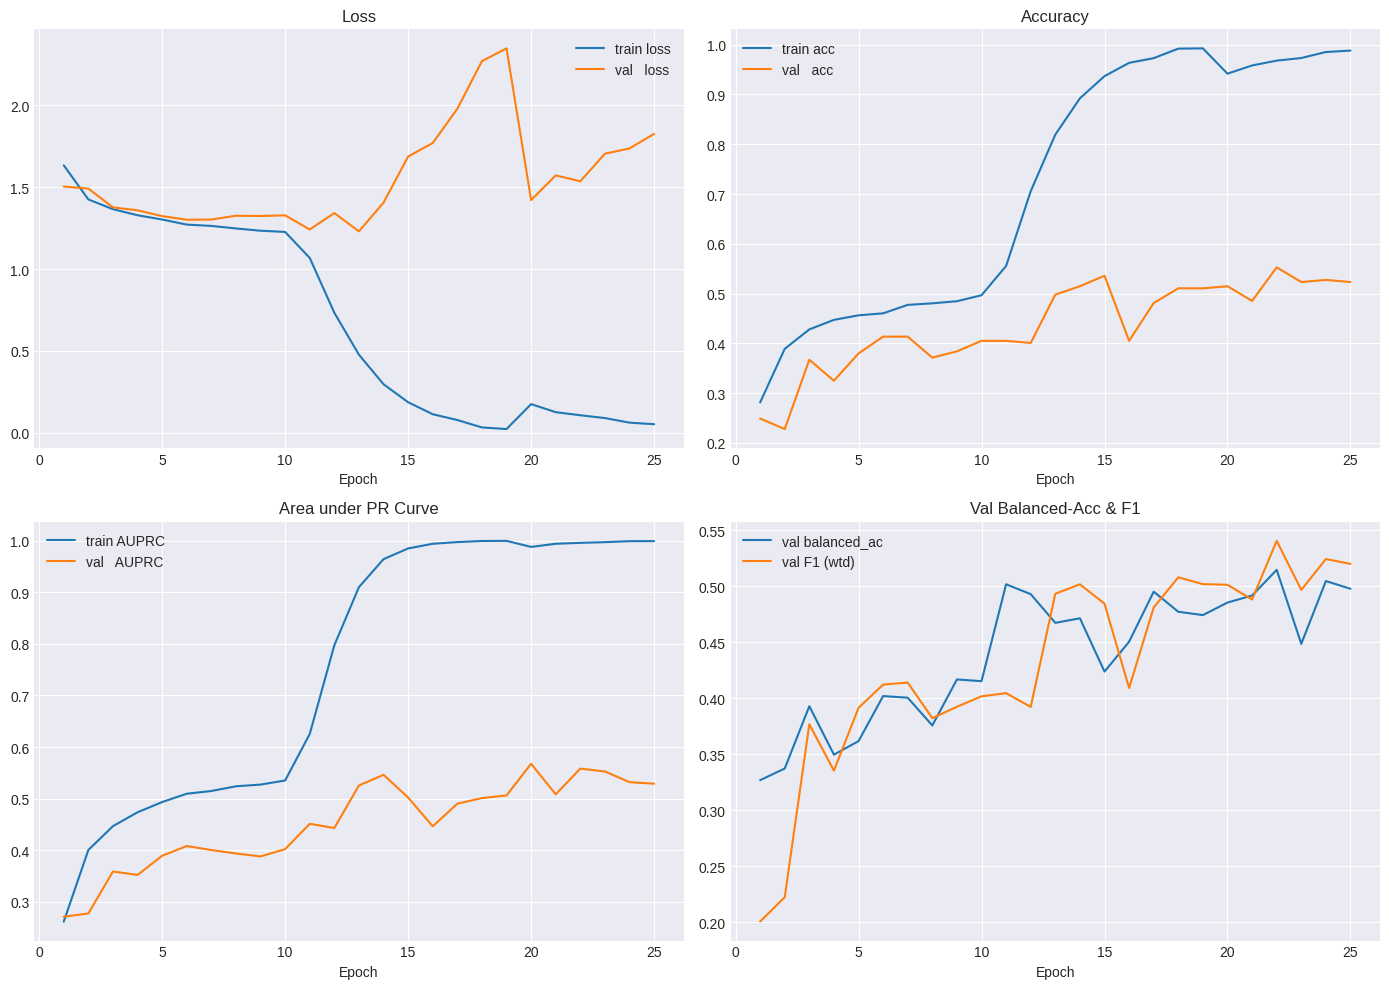

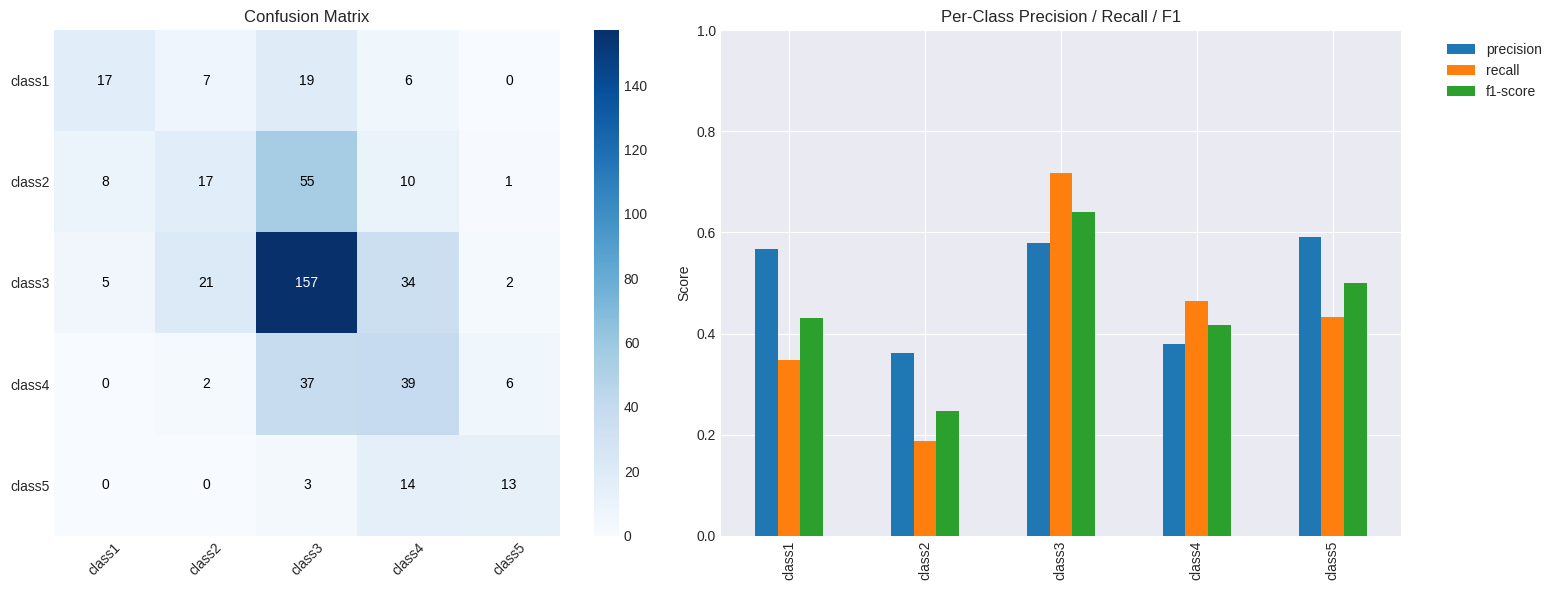


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model1,
    history=history1,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

/tmp/ipykernel_19/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


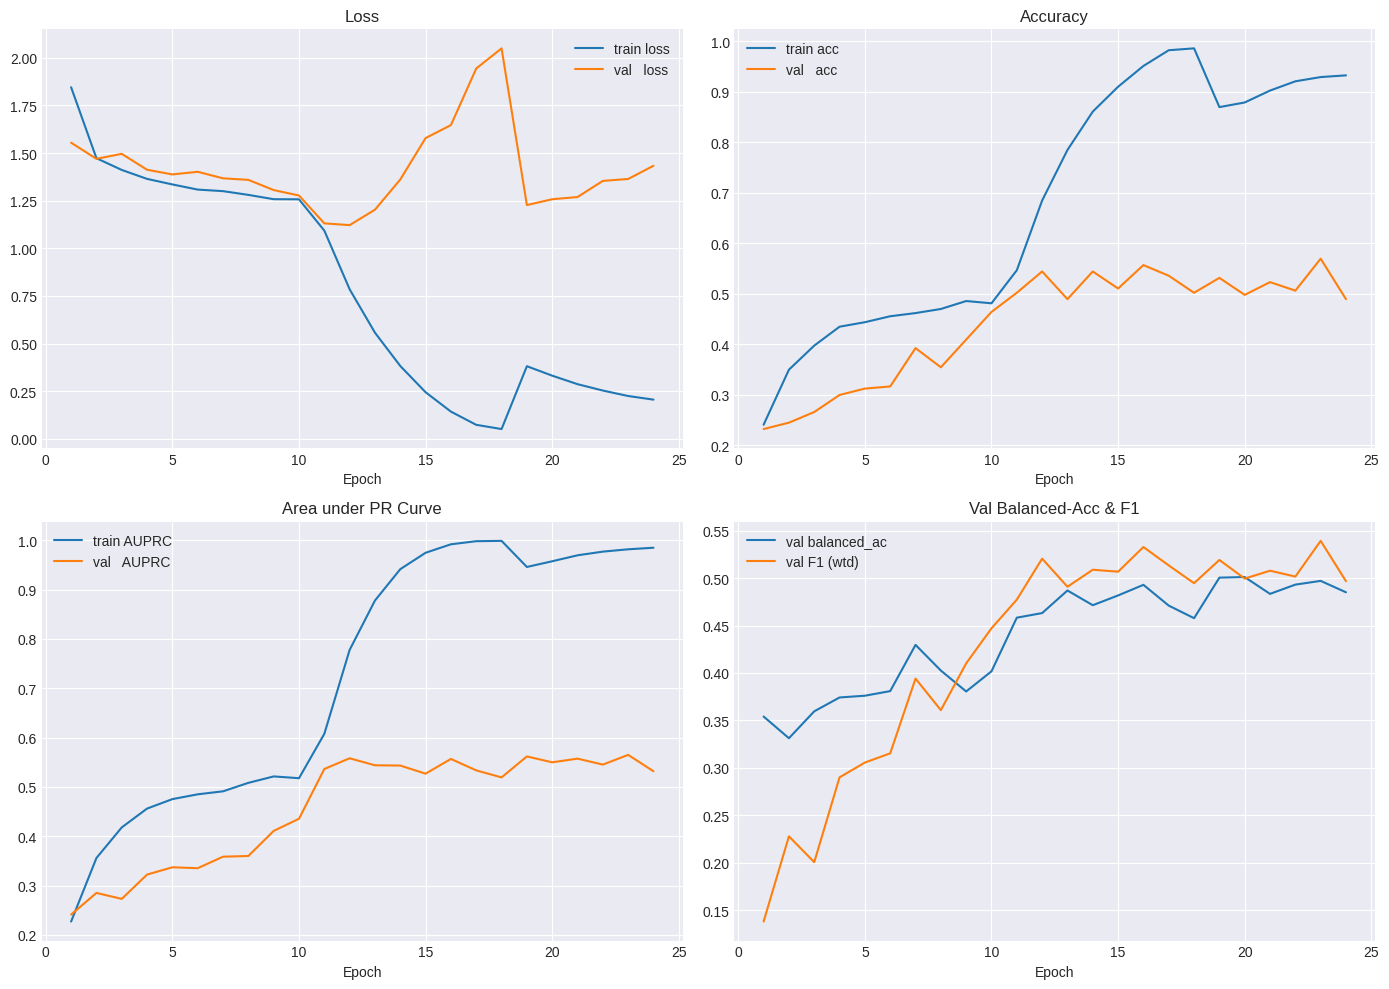

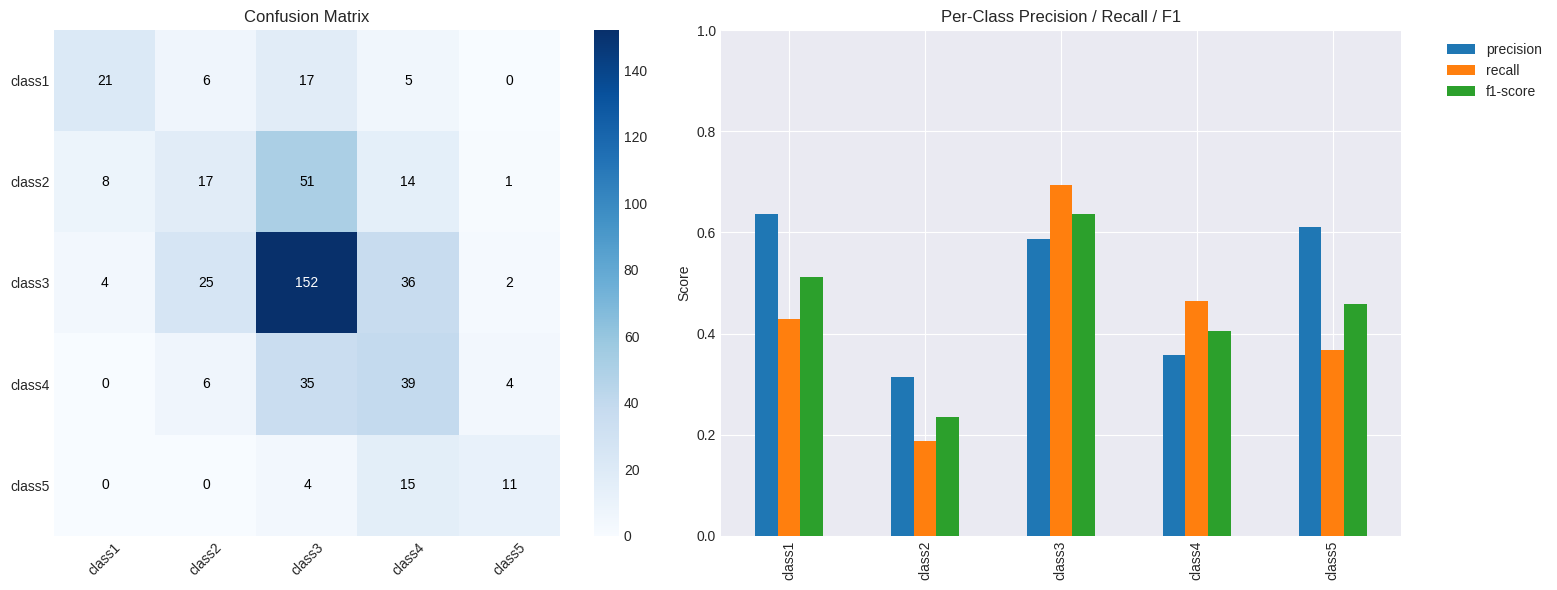


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model2,
    history=history2,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

/tmp/ipykernel_19/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


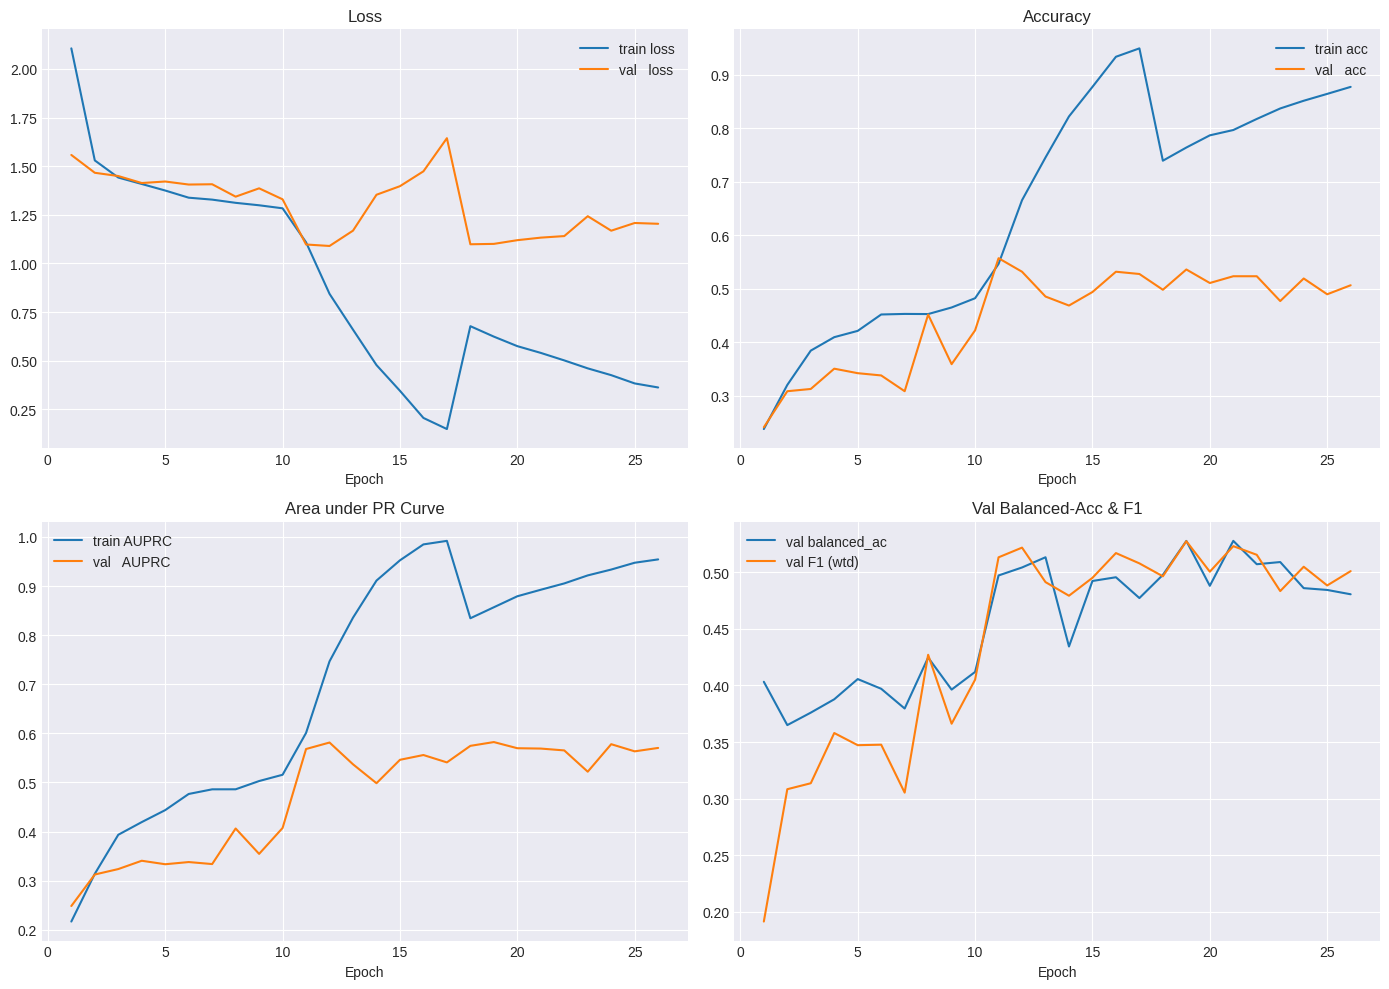

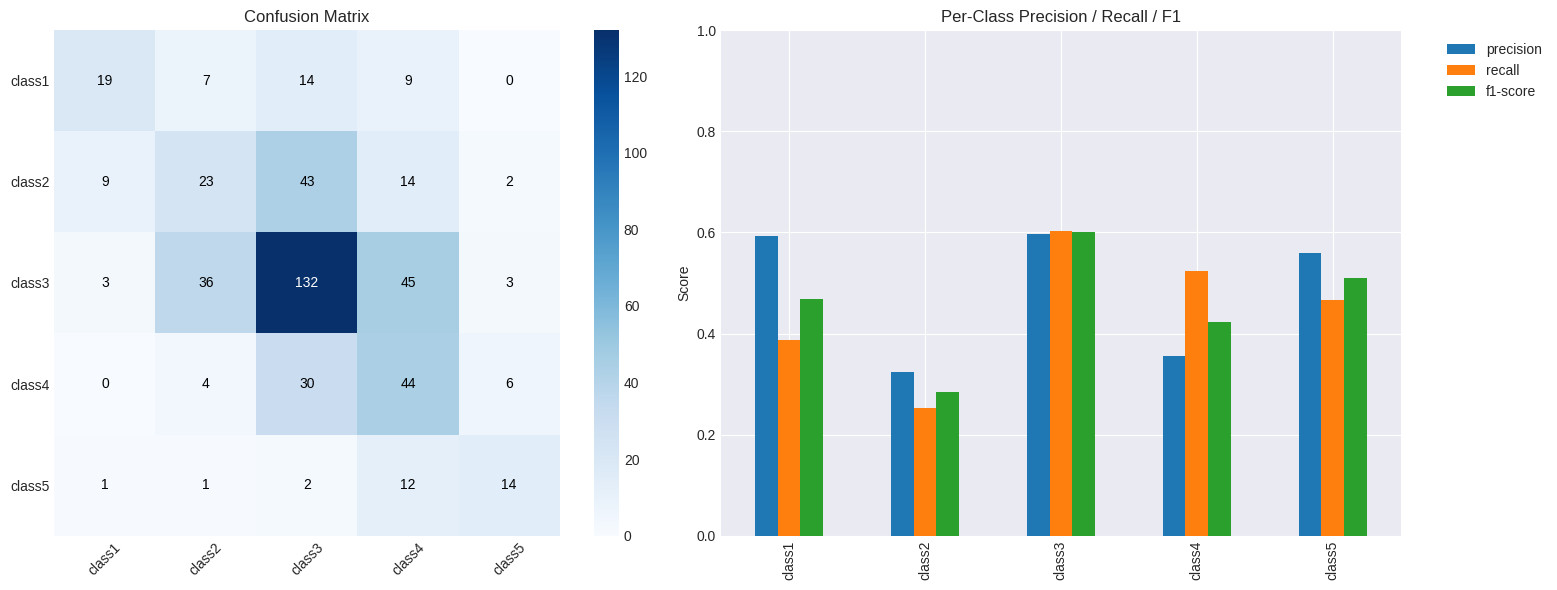


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model3,
    history=history3,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

## Optimizer Search

### Full 5

#### Model

In [ ]:
def get_optimizer(name, lr, momentum=0.9):
    name = name.lower()
    if name == 'adamw':
        return optimizers.AdamW(learning_rate=lr)
    elif name == 'adam':
        return optimizers.Adam(learning_rate=lr)
    elif name == 'sgd':
        return optimizers.SGD(learning_rate=lr, momentum=momentum)
    elif name == 'rmsprop':
        return optimizers.RMSprop(learning_rate=lr, momentum=momentum)
    else:
        raise ValueError(f"Unknown optimizer: {name}")

def train_three_stage(X_train, y_train, X_val, y_val,
                      optimizer_name='adamw',
                      batch_size=32,
                      stage1_epochs=10,
                      stage2_epochs=15,
                      stage3_epochs=20):

    train_ds = make_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
    val_ds   = make_dataset(X_val,   y_val,   batch_size=batch_size, shuffle=False)

    model, backbone = build_convnext_classifier()
    metrics_cb = ValidationMetrics(val_ds)
    es = callbacks.EarlyStopping(
        monitor='val_weighted_auprc', mode='max',
        patience=5, restore_best_weights=True, verbose=1
    )
    ckpt = callbacks.ModelCheckpoint(
        f'best_model_{optimizer_name}.keras',
        monitor='val_weighted_auprc', mode='max',
        save_best_only=True, verbose=1
    )

    history_all = {k: [] for k in [
        'loss', 'accuracy', 'AUPRC',
        'val_loss', 'val_accuracy', 'val_AUPRC',
        'val_balanced_accuracy', 'val_f1_score', 'val_weighted_auprc'
    ]}

    def _fit(epochs, lr, lr_scheduler=None):
        opt = get_optimizer(optimizer_name, lr)
        model.compile(
            optimizer=opt,
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.AUC(curve='PR', name='AUPRC')
            ]
        )
        cbs = [metrics_cb, es, ckpt]
        if lr_scheduler:
            cbs.append(callbacks.LearningRateScheduler(lr_scheduler, verbose=1))
        h = model.fit(
            train_ds, validation_data=val_ds,
            epochs=epochs,
            callbacks=cbs,
            verbose=1
        )
        for k in history_all:
            if k in h.history:
                history_all[k] += h.history[k]
        return h

    # Stage 1
    for layer in backbone.layers:
        layer.trainable = False
    for layer in model.layers[len(backbone.layers):]:
        layer.trainable = True
    print(f"\n=== Stage 1 ({optimizer_name}): head only (lr=1e-3) ===")
    _fit(stage1_epochs, lr=1e-3)

    # Stage 2
    n = len(backbone.layers)
    k = int(n * 0.4)
    for layer in backbone.layers[: n - k]:
        layer.trainable = False
    for layer in backbone.layers[n - k :]:
        layer.trainable = True
    print(f"\n=== Stage 2 ({optimizer_name}): fine-tune last 40% (lr 1e-4→1e-5) ===")
    sched2 = linear_decay_scheduler(1e-4, 1e-5, stage2_epochs)
    _fit(stage2_epochs, lr=1e-4, lr_scheduler=sched2)

    # Stage 3
    for layer in backbone.layers:
        layer.trainable = True
    print(f"\n=== Stage 3 ({optimizer_name}): full fine-tune (lr 1e-5→1e-6) ===")
    sched3 = linear_decay_scheduler(1e-5, 1e-6, stage3_epochs)
    _fit(stage3_epochs, lr=1e-5, lr_scheduler=sched3)

    np.save(f'training_history_{optimizer_name}.npy', history_all)
    print(f"History saved to training_history_{optimizer_name}.npy")

    return model, history_all

In [ ]:
model1, history1 = train_three_stage(
    X_train, y_train, X_val, y_val,
    optimizer_name='rmsprop',
    batch_size=16,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

model2, history2 = train_three_stage(
    X_train, y_train, X_val, y_val,
    optimizer_name='sgd',
    batch_size=16,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

model3, history3 = train_three_stage(
    X_train, y_train, X_val, y_val,
    optimizer_name='adamw',
    batch_size=16,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

model4, history4 = train_three_stage(
    X_train, y_train, X_val, y_val,
    optimizer_name='adam',
    batch_size=16,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

I0000 00:00:1746271400.776654      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

=== Stage 1 (rmsprop): head only (lr=1e-3) ===
Epoch 1/10


I0000 00:00:1746271423.936343      62 service.cc:148] XLA service 0x7f134800d980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746271423.937330      62 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746271425.315777      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/273 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - AUPRC: 0.2715 - accuracy: 0.3104 - loss: 2.2139 

I0000 00:00:1746271429.502872      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - AUPRC: 0.2379 - accuracy: 0.2504 - loss: 1.8287 — val_balanced_accuracy: 0.2315 — val_f1_score: 0.3116 — val_weighted_auprc: 0.3431

Epoch 1: val_weighted_auprc improved from -inf to 0.34306, saving model to best_model_rmsprop.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 53s 123ms/step - AUPRC: 0.2379 - accuracy: 0.2505 - loss: 1.8283 - val_AUPRC: 0.3551 - val_accuracy: 0.3586 - val_loss: 1.4931 - val_balanced_accuracy: 0.2315 - val_f1_score: 0.3116 - val_weighted_auprc: 0.3431
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUPRC: 0.2993 - accuracy: 0.3102 - loss: 1.6331 — val_balanced_accuracy: 0.2750 — val_f1_score: 0.2625 — val_weighted_auprc: 0.3404

Epoch 2: val_weighted_auprc did not improve from 0.34306
273/273 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - AUPRC: 0.2993 - accuracy: 0.3102 - loss: 1.6331 - val_AUPRC: 0.2702 - val_accuracy: 0.2827 - val_loss: 1.5351 - val_balanced_accuracy: 0.2750 - val_f1_score: 0.2625 - val_weighted_auprc: 0.3404

E0000 00:00:1746271594.023785      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746271594.199095      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746271594.438991      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746271594.631650      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


272/273 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - AUPRC: 0.2569 - accuracy: 0.2649 - loss: 2.0227

E0000 00:00:1746271627.671082      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746271627.846439      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746271628.085637      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746271628.277702      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - AUPRC: 0.2571 - accuracy: 0.2650 - loss: 2.0218 — val_balanced_accuracy: 0.2878 — val_f1_score: 0.3240 — val_weighted_auprc: 0.4051

Epoch 1: val_weighted_auprc improved from 0.35558 to 0.40507, saving model to best_model_rmsprop.keras
273/273 ━━━━━━━━━━━━━━━━━━━━ 89s 196ms/step - AUPRC: 0.2572 - accuracy: 0.2651 - loss: 2.0209 - val_AUPRC: 0.4331 - val_accuracy: 0.4388 - val_loss: 1.3701 - val_balanced_accuracy: 0.2878 - val_f1_score: 0.3240 - val_weighted_auprc: 0.4051 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.357142857142858e-05.
Epoch 2/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - AUPRC: 0.5204 - accuracy: 0.4648 - loss: 1.2754 — val_balanced_accuracy: 0.2511 — val_f1_score: 0.2618 — val_weighted_auprc: 0.3710

Epoch 2: val_weighted_auprc did not improve from 0.40507
273/273 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - AUPRC: 0.5206 - accuracy: 0.4650 - loss: 1.2752 - val_AUPRC: 0.2609 - val_accurac

#### Evaluation

/tmp/ipykernel_19/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


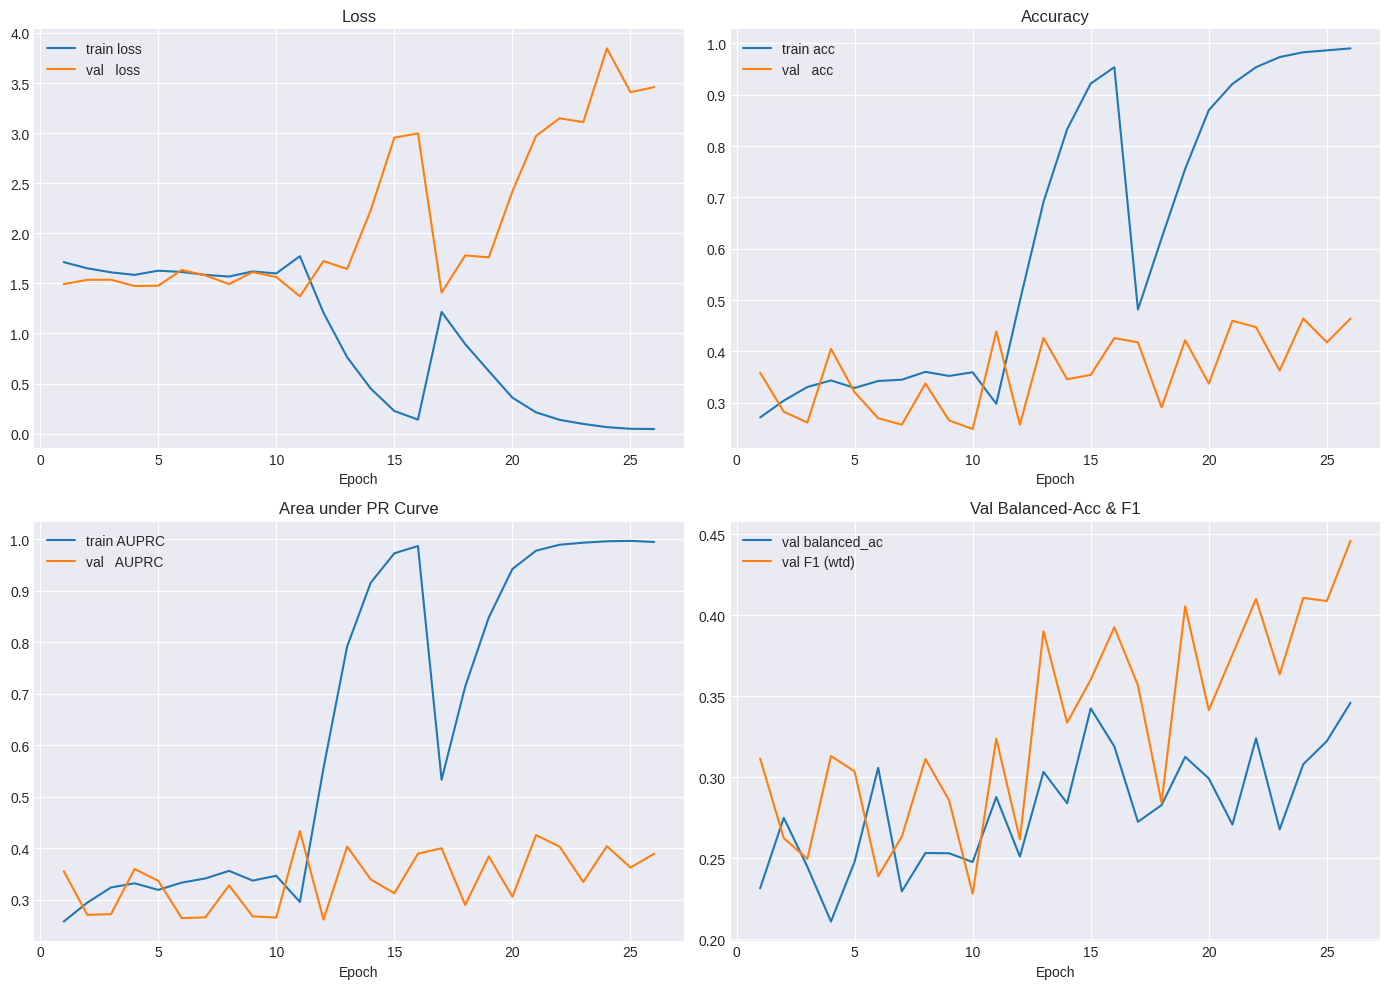

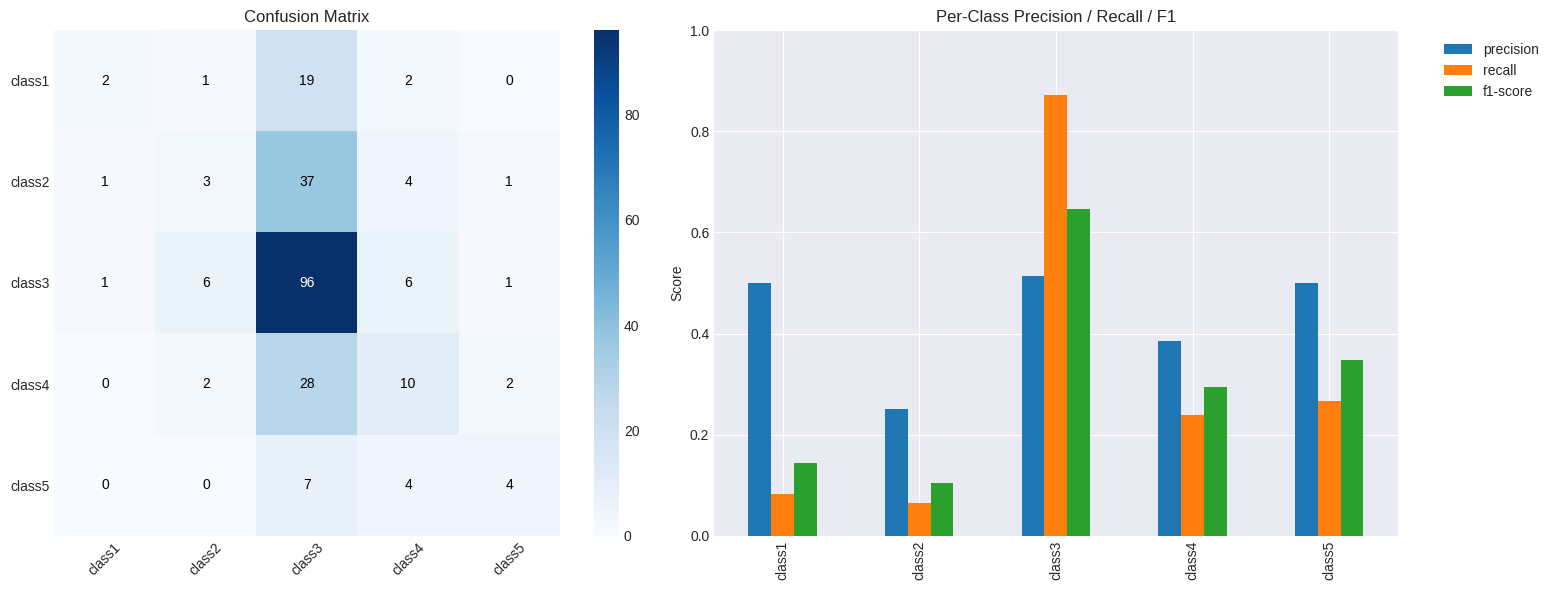


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model1,
    history=history1,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

/tmp/ipykernel_19/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


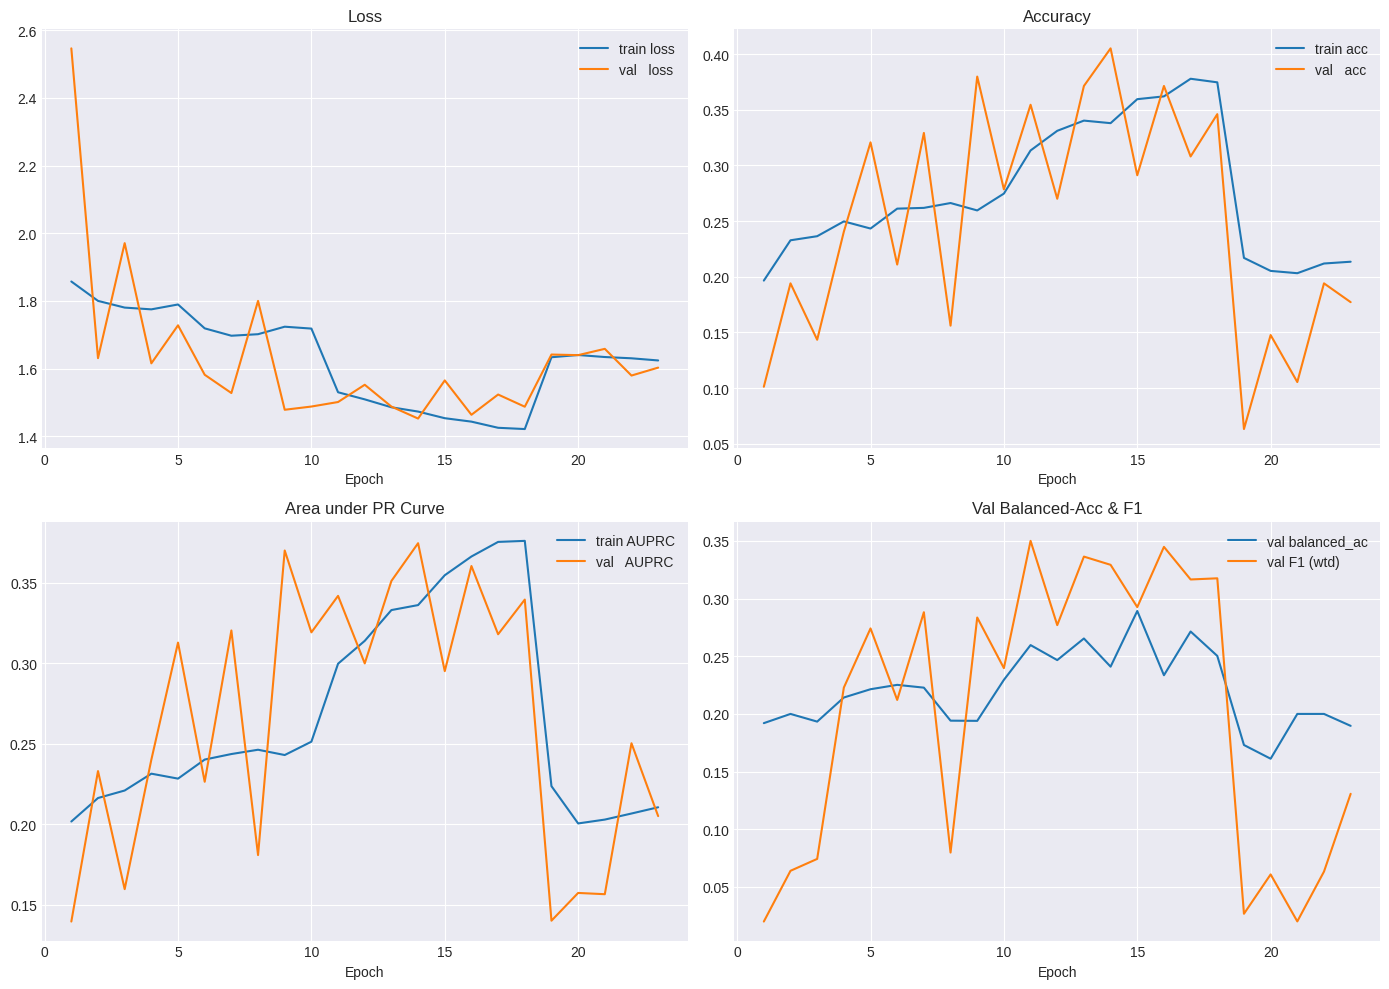

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


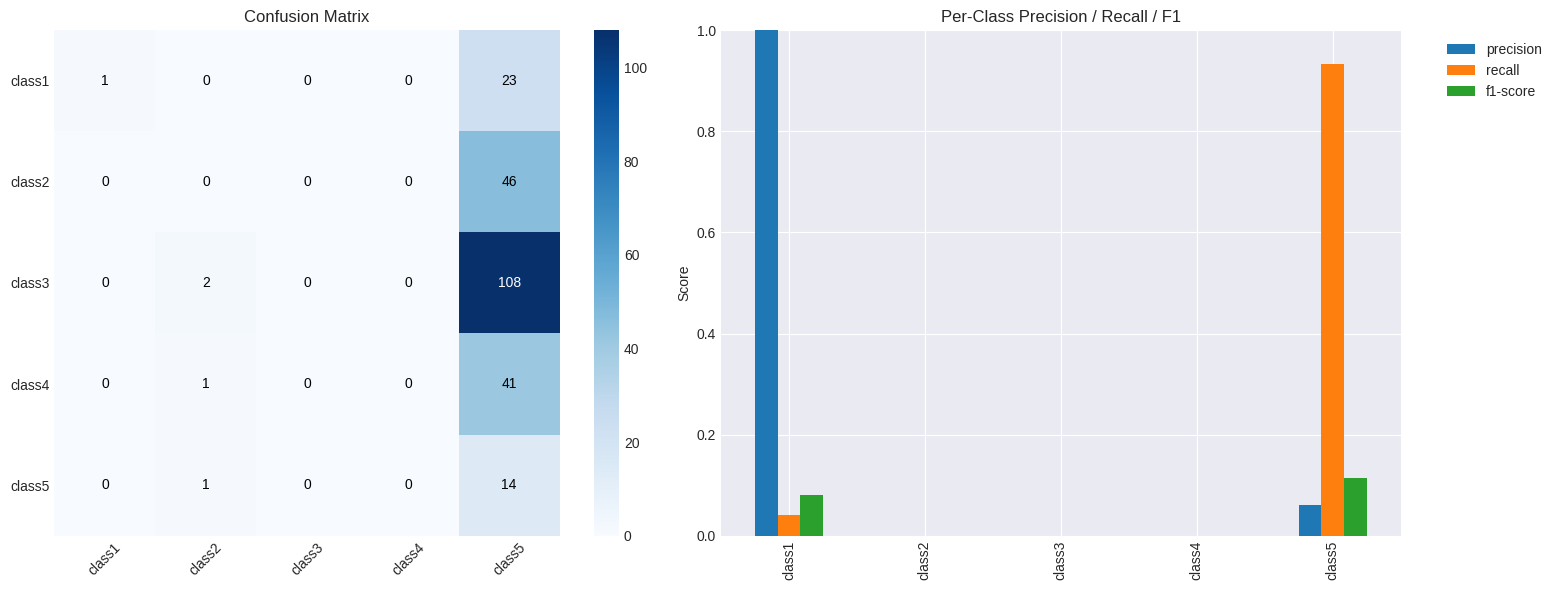


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model2,
    history=history2,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

/tmp/ipykernel_19/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


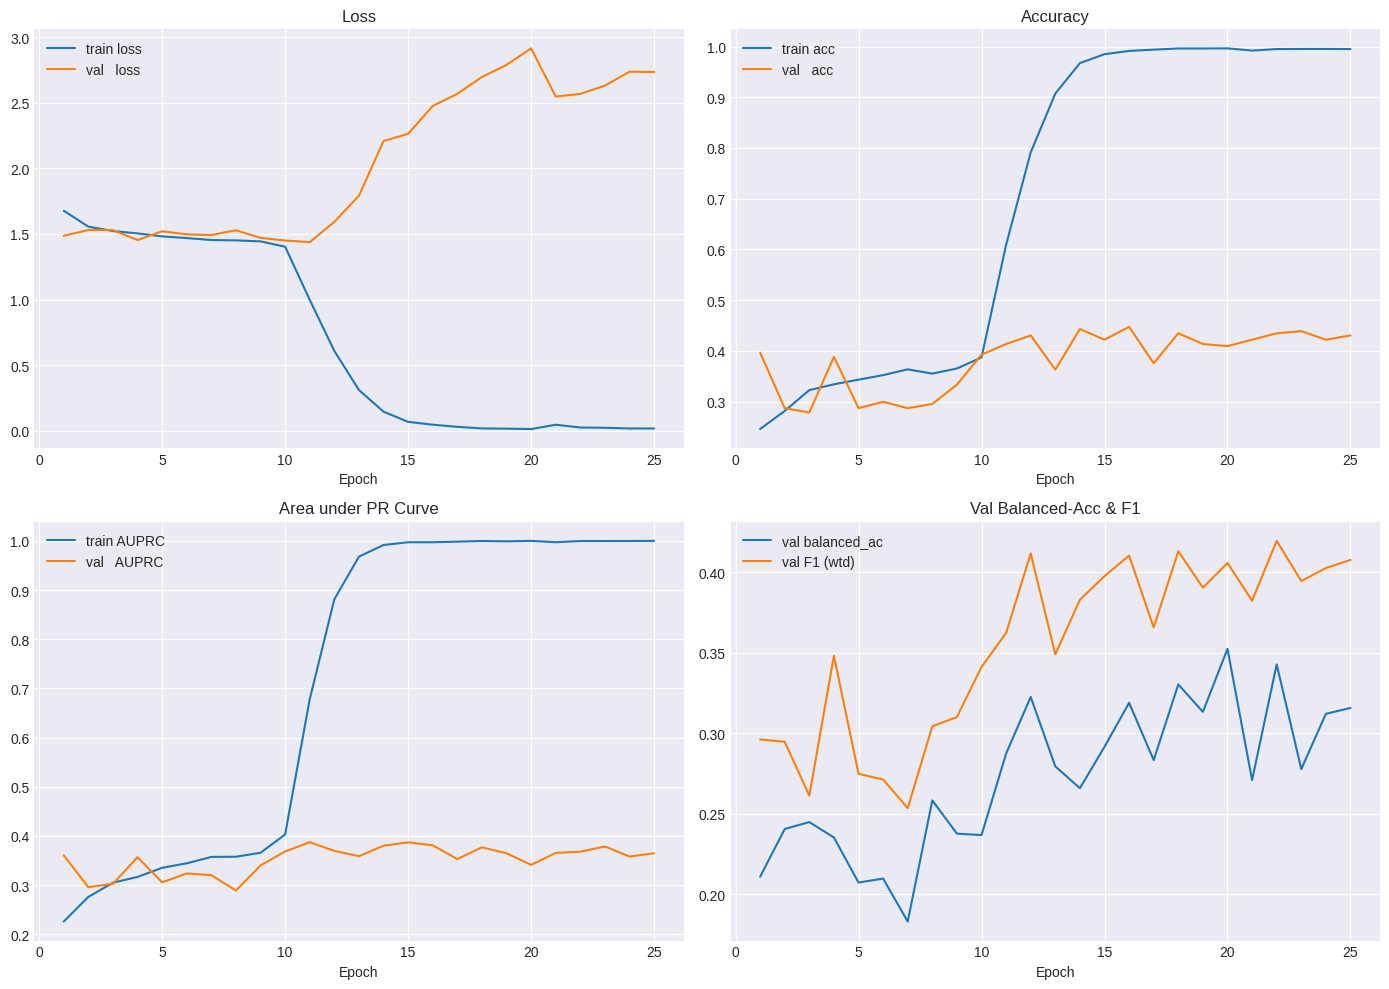

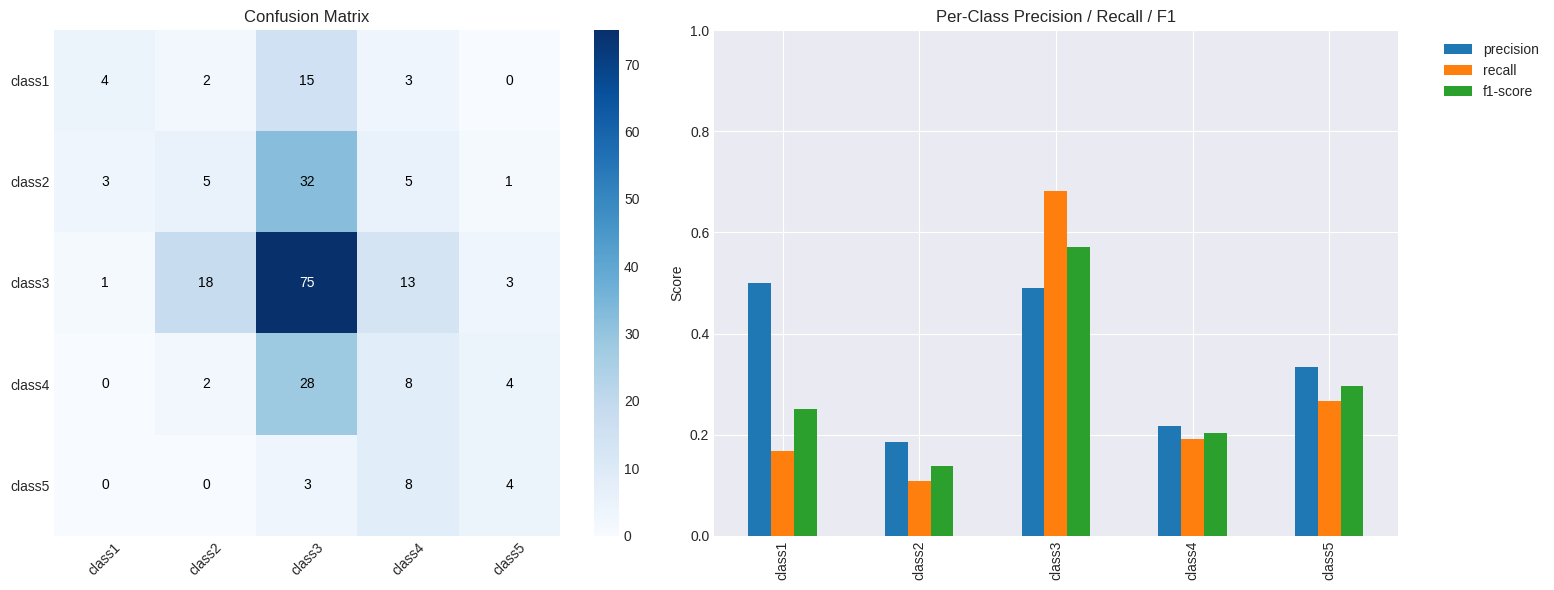


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model3,
    history=history3,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

/tmp/ipykernel_19/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


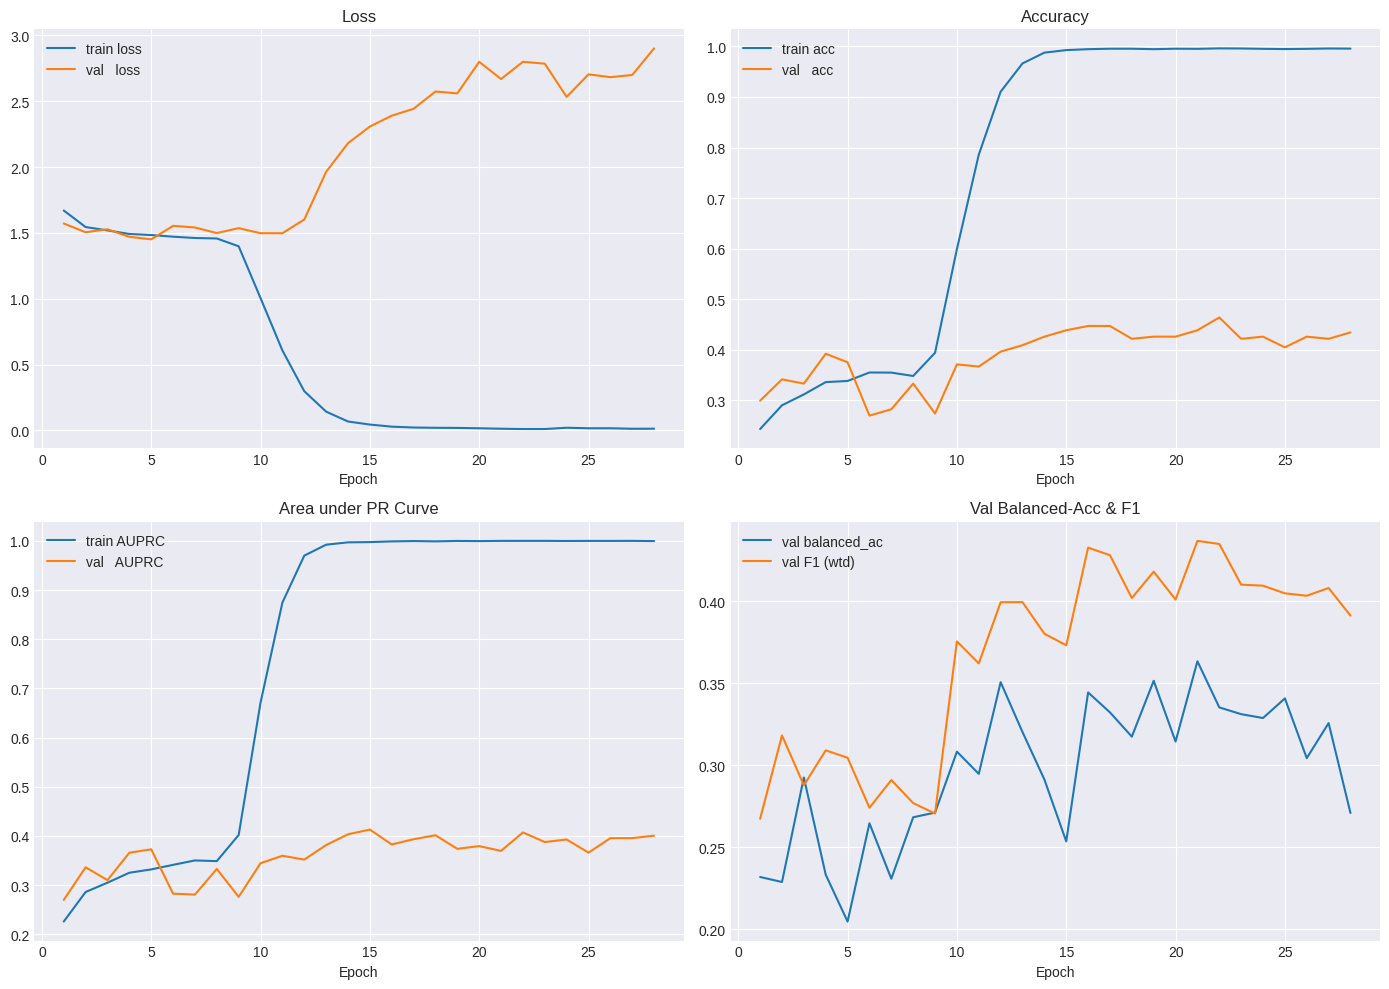

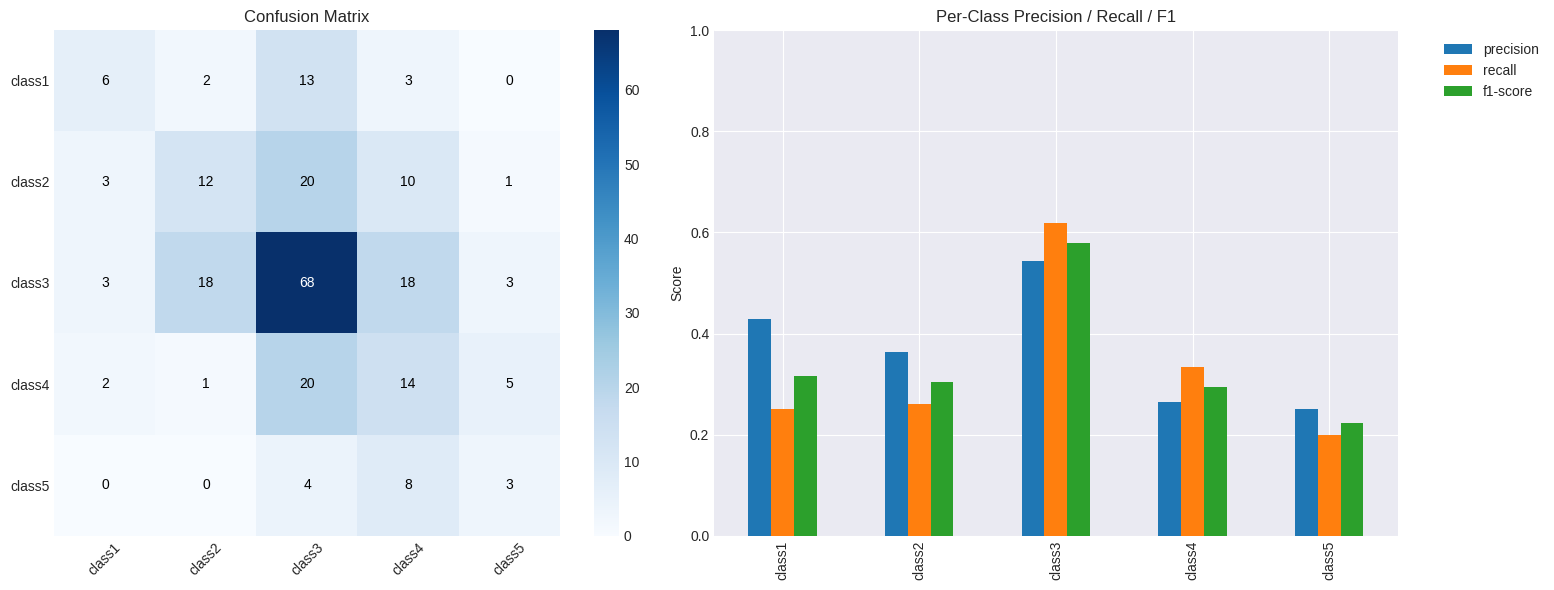


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model4,
    history=history4,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

### Nodule 5

#### Model

In [ ]:
class ValidationMetrics(callbacks.Callback):
    def __init__(self, val_dataset):
        super().__init__()
        self.val_ds = val_dataset
        self.history = {
            'val_balanced_accuracy': [],
            'val_f1_score': [],
            'val_weighted_auprc': []
        }

    def on_epoch_end(self, epoch, logs=None):
        y_true, y_pred = [], []
        for x_batch, y_batch in self.val_ds:
            preds = self.model.predict(x_batch, verbose=0)
            y_true.append(y_batch.numpy())
            y_pred.append(preds)
        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)
        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)

        bal_acc = balanced_accuracy_score(y_true_labels, y_pred_labels)
        f1      = f1_score(y_true_labels, y_pred_labels, average='weighted')
        auprc_w = average_precision_score(y_true, y_pred, average='weighted')

        logs = logs or {}
        logs['val_balanced_accuracy'] = bal_acc
        logs['val_f1_score']          = f1
        logs['val_weighted_auprc']    = auprc_w

        self.history['val_balanced_accuracy'].append(bal_acc)
        self.history['val_f1_score'].append(f1)
        self.history['val_weighted_auprc'].append(auprc_w)

        print(f" — val_balanced_accuracy: {bal_acc:.4f}"
              f" — val_f1_score: {f1:.4f}"
              f" — val_weighted_auprc: {auprc_w:.4f}")

def build_convnext_classifier(input_shape=(224,224,3), num_classes=5, dropout=0.5):
    base = ConvNeXtTiny(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    model = models.Model(inputs=base.input, outputs=out)
    return model, base

AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(X, y, batch_size=32, shuffle=False):
    def _prep(img, label):
        img = tf.cast(img, tf.float32)
        img = tf.expand_dims(img, axis=-1)
        img = tf.image.grayscale_to_rgb(img)
        img = tf.keras.applications.convnext.preprocess_input(img)
        return img, tf.one_hot(label-1, depth=5)

    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    ds = ds.map(_prep, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


def get_optimizer(name, lr, momentum=0.9):
    name = name.lower()
    if name == 'adamw':
        return optimizers.AdamW(learning_rate=lr)
    elif name == 'sgd':
        return optimizers.SGD(learning_rate=lr, momentum=momentum)
    elif name == 'rmsprop':
        return optimizers.RMSprop(learning_rate=lr, momentum=momentum)
    else:
        raise ValueError(f"Unknown optimizer: {name}")

def train_three_stage(X_train, y_train, X_val, y_val,
                      optimizer_name='adamw',
                      batch_size=32,
                      stage1_epochs=10,
                      stage2_epochs=15,
                      stage3_epochs=20):

    train_ds = make_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
    val_ds   = make_dataset(X_val,   y_val,   batch_size=batch_size, shuffle=False)

    model, backbone = build_convnext_classifier()
    metrics_cb = ValidationMetrics(val_ds)
    es = callbacks.EarlyStopping(
        monitor='val_weighted_auprc', mode='max',
        patience=5, restore_best_weights=True, verbose=1
    )
    ckpt = callbacks.ModelCheckpoint(
        f'best_model_{optimizer_name}.keras',
        monitor='val_weighted_auprc', mode='max',
        save_best_only=True, verbose=1
    )

    history_all = {k: [] for k in [
        'loss', 'accuracy', 'AUPRC',
        'val_loss', 'val_accuracy', 'val_AUPRC',
        'val_balanced_accuracy', 'val_f1_score', 'val_weighted_auprc'
    ]}

    def _fit(epochs, lr, lr_scheduler=None):
        opt = get_optimizer(optimizer_name, lr)
        model.compile(
            optimizer=opt,
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.AUC(curve='PR', name='AUPRC')
            ]
        )
        cbs = [metrics_cb, es, ckpt]
        if lr_scheduler:
            cbs.append(callbacks.LearningRateScheduler(lr_scheduler, verbose=1))
        h = model.fit(
            train_ds, validation_data=val_ds,
            epochs=epochs,
            callbacks=cbs,
            verbose=1
        )
        for k in history_all:
            if k in h.history:
                history_all[k] += h.history[k]
        return h

    # Stage 1
    for layer in backbone.layers:
        layer.trainable = False
    for layer in model.layers[len(backbone.layers):]:
        layer.trainable = True
    print(f"\n=== Stage 1 ({optimizer_name}): head only (lr=1e-3) ===")
    _fit(stage1_epochs, lr=1e-3)

    # Stage 2
    n = len(backbone.layers)
    k = int(n * 0.4)
    for layer in backbone.layers[: n - k]:
        layer.trainable = False
    for layer in backbone.layers[n - k :]:
        layer.trainable = True
    print(f"\n=== Stage 2 ({optimizer_name}): fine-tune last 40% (lr 1e-4→1e-5) ===")
    sched2 = linear_decay_scheduler(1e-4, 1e-5, stage2_epochs)
    _fit(stage2_epochs, lr=1e-4, lr_scheduler=sched2)

    # Stage 3
    for layer in backbone.layers:
        layer.trainable = True
    print(f"\n=== Stage 3 ({optimizer_name}): full fine-tune (lr 1e-5→1e-6) ===")
    sched3 = linear_decay_scheduler(1e-5, 1e-6, stage3_epochs)
    _fit(stage3_epochs, lr=1e-5, lr_scheduler=sched3)

    np.save(f'training_history_{optimizer_name}.npy', history_all)
    print(f"History saved to training_history_{optimizer_name}.npy")

    return model, history_all

In [ ]:
model1, history1 = train_three_stage(
    X_train, y_train, X_val, y_val,
    optimizer_name='rmsprop',
    batch_size=32,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

model2, history2 = train_three_stage(
    X_train, y_train, X_val, y_val,
    optimizer_name='sgd',
    batch_size=32,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

model3, history3 = train_three_stage(
    X_train, y_train, X_val, y_val,
    optimizer_name='adamw',
    batch_size=32,
    stage1_epochs=10,
    stage2_epochs=15,
    stage3_epochs=20
)

I0000 00:00:1745782691.577342      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

=== Stage 1 (rmsprop): head only (lr=1e-3) ===
Epoch 1/10


I0000 00:00:1745782711.111161      60 service.cc:148] XLA service 0x7c9f3000b230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745782711.111953      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745782712.565874      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/120 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - AUPRC: 0.1975 - accuracy: 0.2031 - loss: 2.6684  

I0000 00:00:1745782717.453693      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUPRC: 0.2853 - accuracy: 0.2919 - loss: 1.7869 — val_balanced_accuracy: 0.4106 — val_f1_score: 0.3662 — val_weighted_auprc: 0.4348

Epoch 1: val_weighted_auprc improved from -inf to 0.43483, saving model to best_model_rmsprop.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 54s 275ms/step - AUPRC: 0.2859 - accuracy: 0.2924 - loss: 1.7849 - val_AUPRC: 0.3667 - val_accuracy: 0.3671 - val_loss: 1.3667 - val_balanced_accuracy: 0.4106 - val_f1_score: 0.3662 - val_weighted_auprc: 0.4348
Epoch 2/10
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - AUPRC: 0.4461 - accuracy: 0.4169 - loss: 1.3684 — val_balanced_accuracy: 0.3768 — val_f1_score: 0.4278 — val_weighted_auprc: 0.4486

Epoch 2: val_weighted_auprc improved from 0.43483 to 0.44855, saving model to best_model_rmsprop.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - AUPRC: 0.4464 - accuracy: 0.4171 - loss: 1.3680 - val_AUPRC: 0.4573 - val_accuracy: 0.5063 - val_loss: 1.2418 - val_balanced_accuracy: 0.3768 - val

E0000 00:00:1745782864.052249      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745782864.245353      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745782864.448092      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745782864.624294      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - AUPRC: 0.4452 - accuracy: 0.4189 - loss: 1.6224

E0000 00:00:1745782894.244162      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745782894.419603      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745782894.638842      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745782894.831768      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - AUPRC: 0.4456 - accuracy: 0.4193 - loss: 1.6209 — val_balanced_accuracy: 0.4441 — val_f1_score: 0.5350 — val_weighted_auprc: 0.5226

Epoch 1: val_weighted_auprc improved from 0.49131 to 0.52262, saving model to best_model_rmsprop.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 87s 419ms/step - AUPRC: 0.4461 - accuracy: 0.4198 - loss: 1.6194 - val_AUPRC: 0.5379 - val_accuracy: 0.5738 - val_loss: 1.1948 - val_balanced_accuracy: 0.4441 - val_f1_score: 0.5350 - val_weighted_auprc: 0.5226 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.357142857142858e-05.
Epoch 2/15
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - AUPRC: 0.7055 - accuracy: 0.6101 - loss: 0.9749 — val_balanced_accuracy: 0.4811 — val_f1_score: 0.2654 — val_weighted_auprc: 0.5098

Epoch 2: val_weighted_auprc did not improve from 0.52262
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - AUPRC: 0.7059 - accuracy: 0.6105 - loss: 0.9738 - val_AUPRC: 0.3737 - val_accur

#### Evaluation

/tmp/ipykernel_19/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


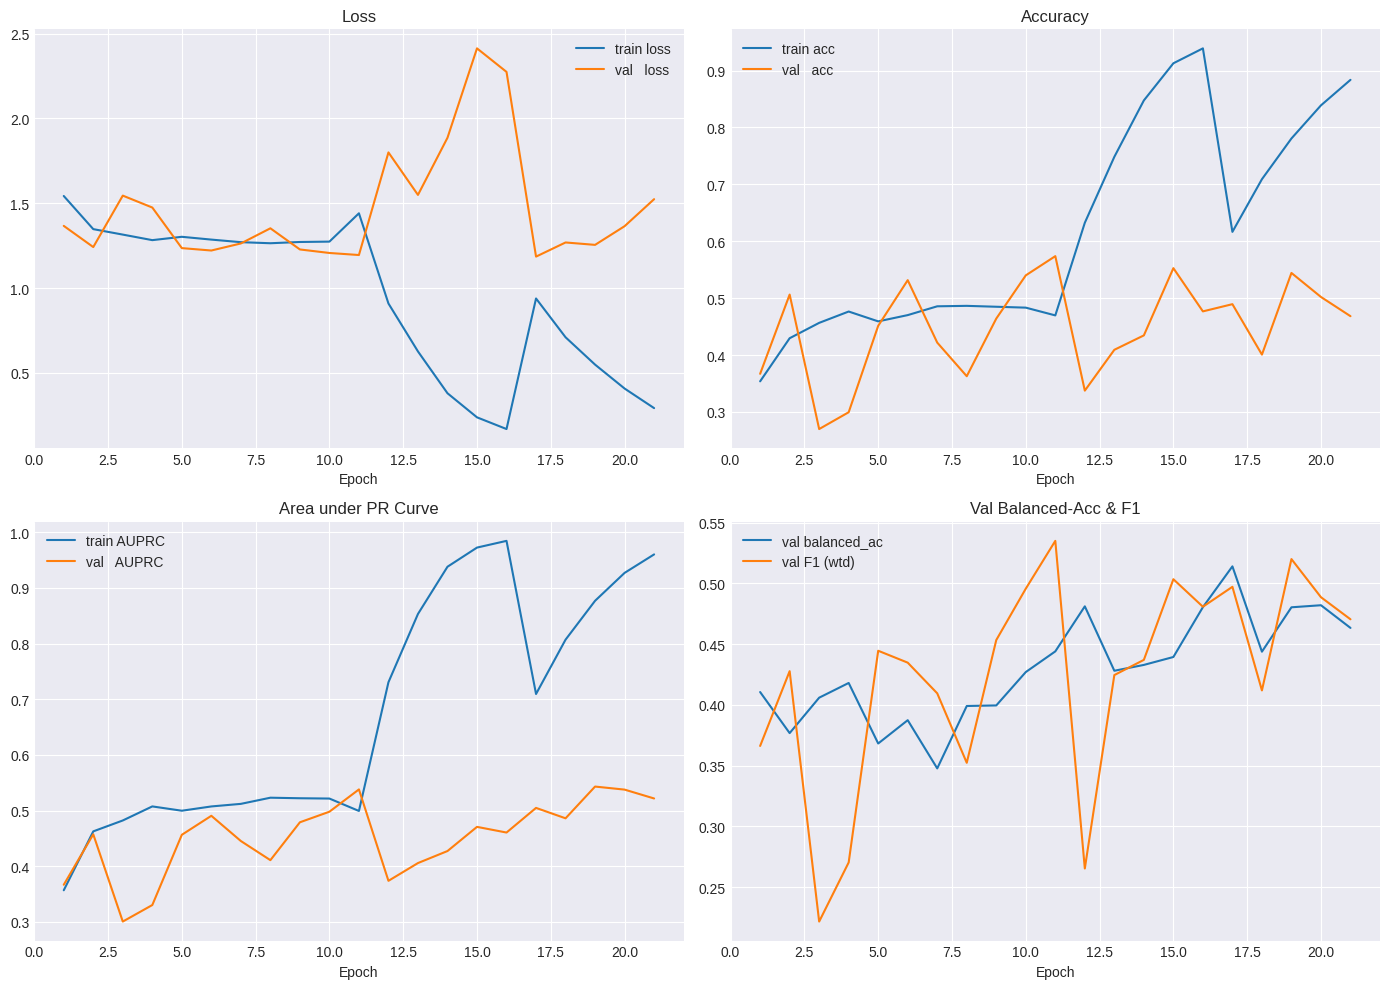

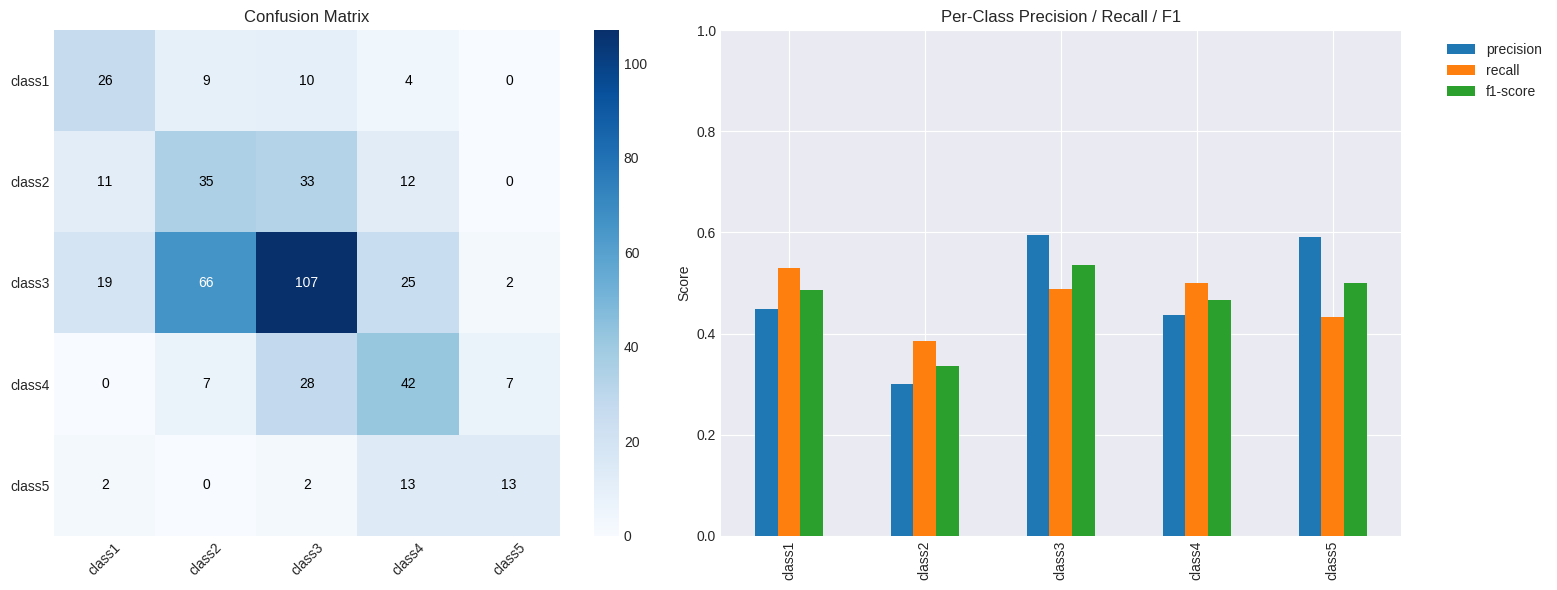


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:

evaluate_model(
    model=model1,
    history=history1,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

/tmp/ipykernel_19/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


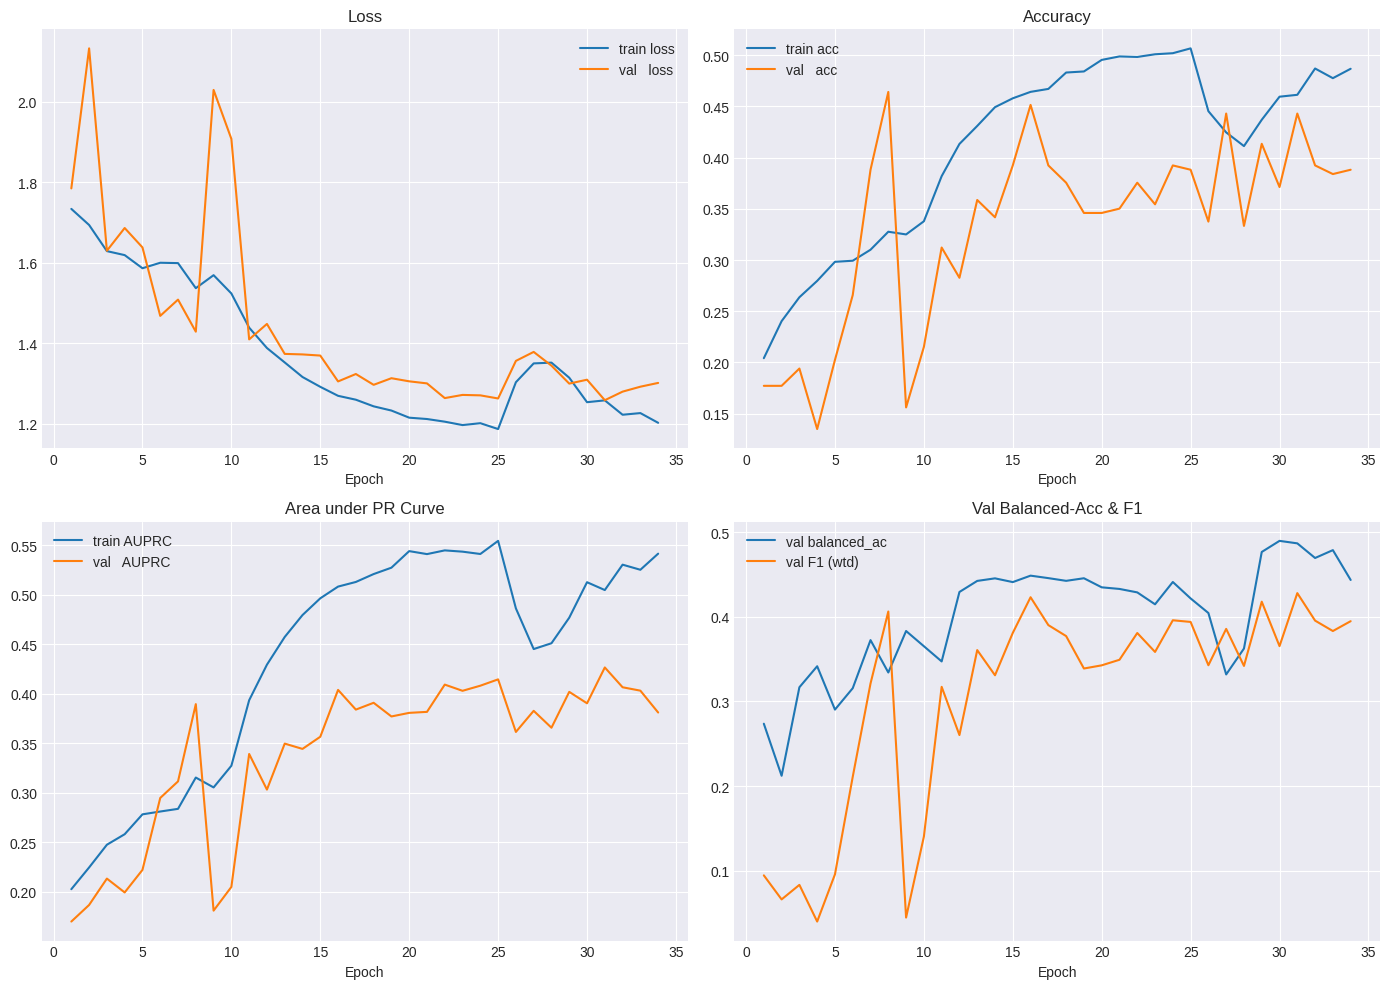

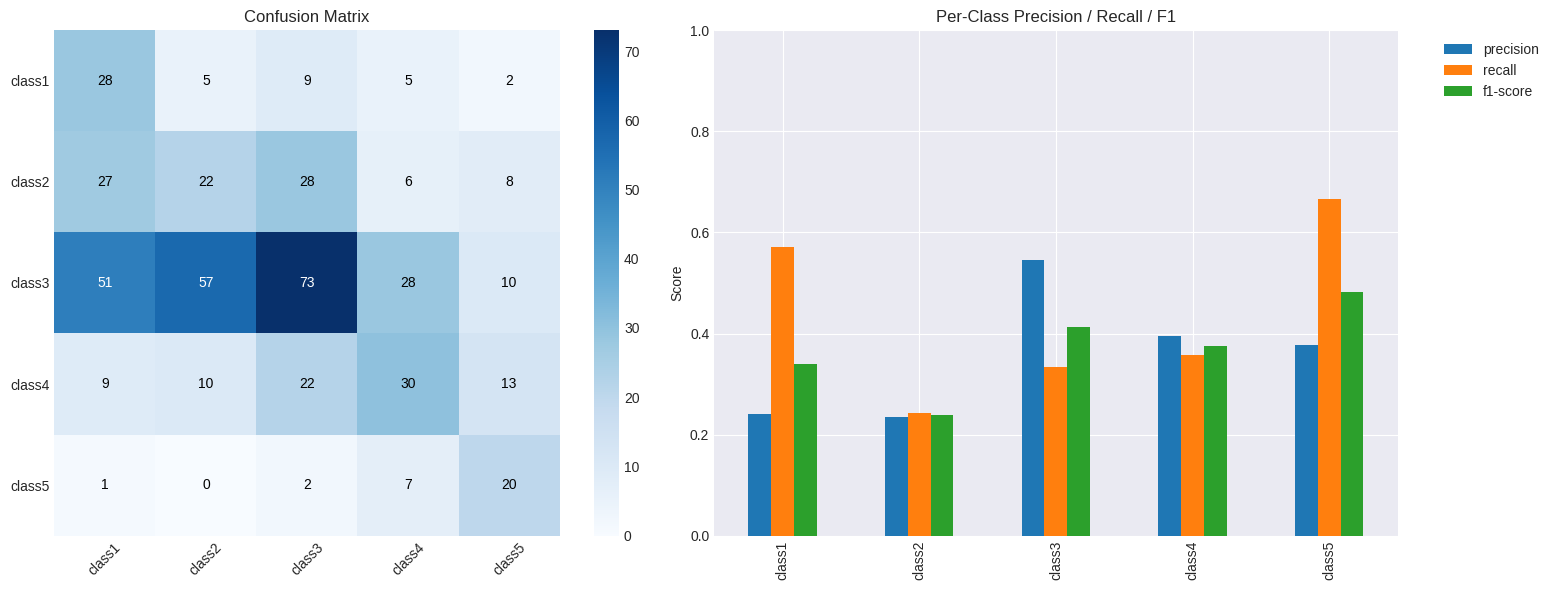


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model2,
    history=history2,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)

/tmp/ipykernel_19/3601267246.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


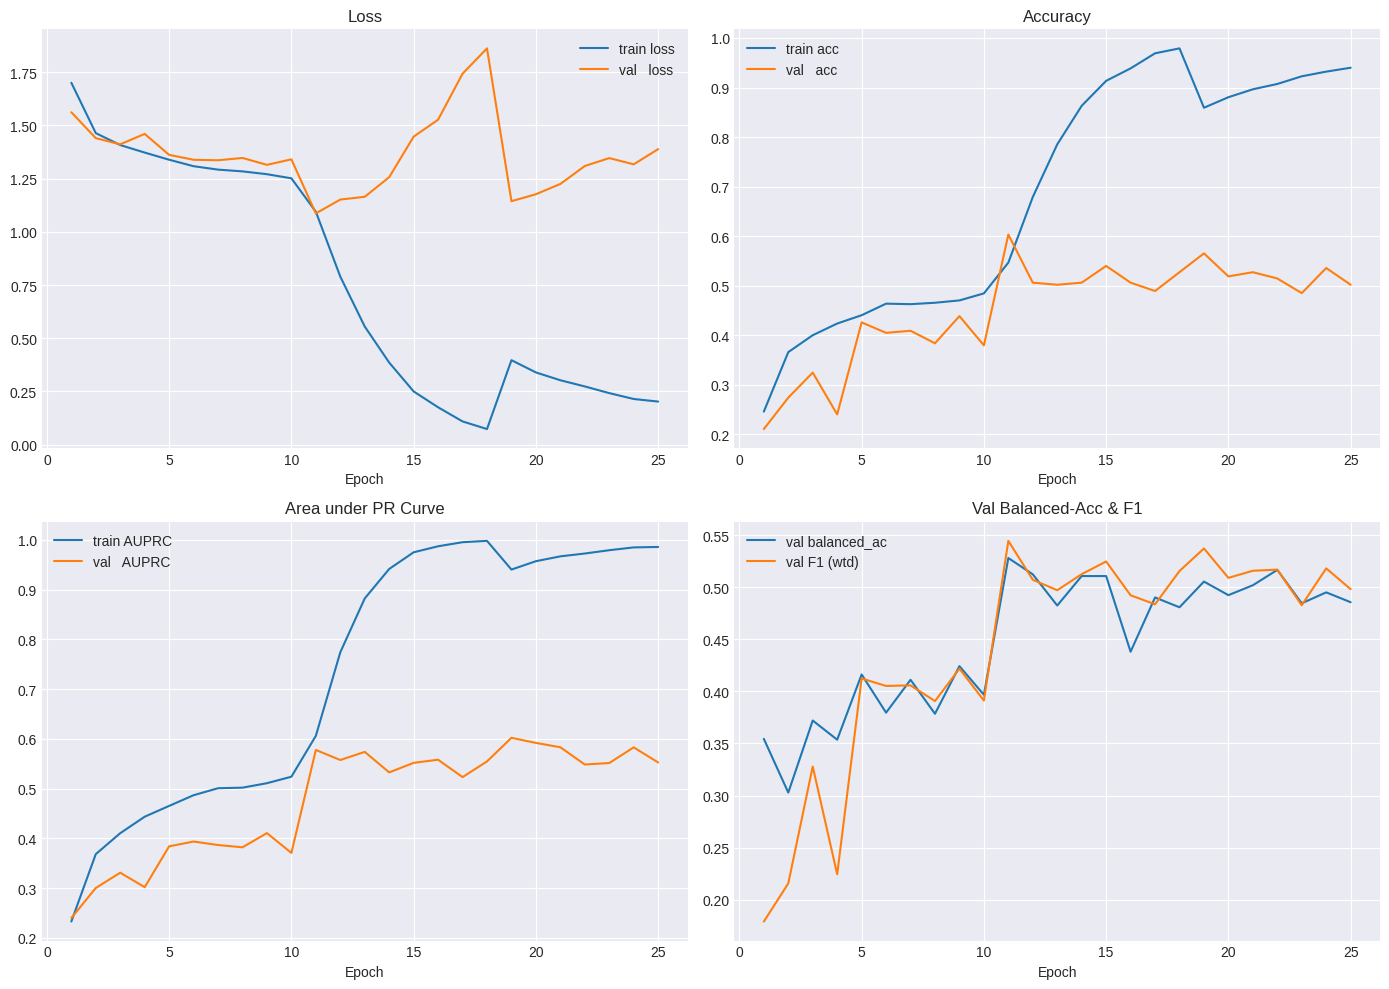

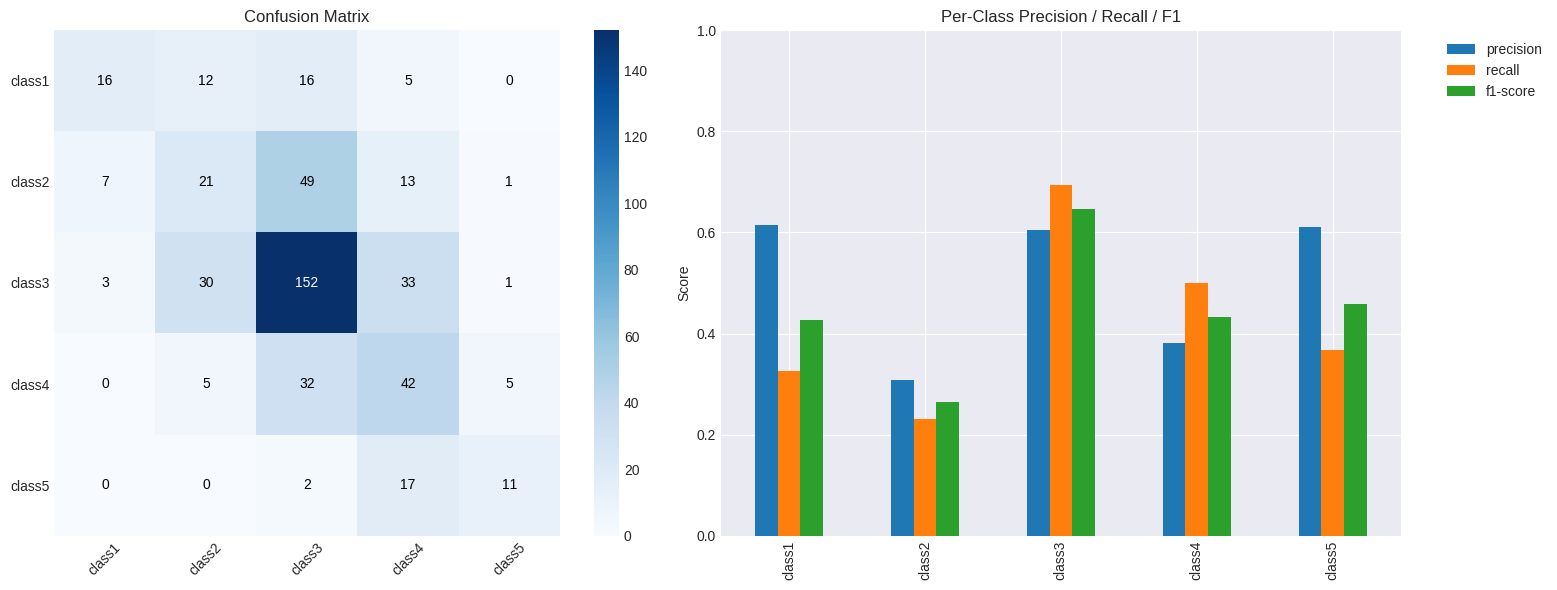


=== Overall Test Metrics ===



=== Classification Report ===


In [ ]:
evaluate_model(
    model=model3,
    history=history3,
    X_test=X_test,
    y_test=y_test,
    class_names=['class1','class2','class3','class4','class5']
)